<a href="https://colab.research.google.com/github/eduardohen1/OutlierDetection_PMU_UNIFEI2023/blob/main/OutlierDetection_PMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PMU Parquet Dataset

Dataset é um **DownSample** das bases originais em minutos.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1fdkgRTJkYo_pPZCUI0mHMyBuiisAkmfE/view?usp=share_link -O Database_Parquet.zip
!unzip -qq Database_Parquet.zip
!rm Database_Parquet.zip

Downloading...
From: https://drive.google.com/uc?id=1fdkgRTJkYo_pPZCUI0mHMyBuiisAkmfE
To: /content/Database_Parquet.zip
100% 4.14M/4.14M [00:00<00:00, 202MB/s]


In [ ]:
import glob
parquets = glob.glob('*.parquet')
len(parquets), parquets[:5]

(149,
 ['evento 2 - 28-05-2021 - 1023.parquet',
  'evento 1 - 08-04-2021 - 1010.parquet',
  'evento 2 - 28-05-2021 - 1144.parquet',
  'evento 1 - 08-04-2021 - 3087.parquet',
  'evento 1 - 08-04-2021 - 1116.parquet'])

# Eventos de Estudo

In [ ]:
from datetime import datetime

eventos =[
    datetime(2021,4,8,18,34,0),
    datetime(2021,5,28,11,6,0),
    datetime(2021,5,28,11,26,0),
    datetime(2021,5,28,23,28,0),
    ]
eventos

[datetime.datetime(2021, 4, 8, 18, 34),
 datetime.datetime(2021, 5, 28, 11, 6),
 datetime.datetime(2021, 5, 28, 11, 26),
 datetime.datetime(2021, 5, 28, 23, 28)]

## Extraindo bases para eventos

Configurações:

In [ ]:
from datetime import timedelta
import pandas as pd
import warnings

def medidas(arquivos, evento:datetime, tempo_antes=240, tempo_depois=4) -> pd.DataFrame:
  # inicio e fim das medidas do evento
  data_ini = evento - timedelta(minutes=tempo_antes)
  data_fim = evento + timedelta(minutes=tempo_depois)
  tabelas = []
  # lista arquivos com tabelas
  for parquet in arquivos:
    df = pd.read_parquet(parquet)
    mascara = (df['instante'] >= data_ini) & (df['instante'] < data_fim)
    df = df[mascara]
    # ignora resultado zero do filtro de tempo
    if len(df) == 0:
      del df
      continue
    # adiciona apenas tabelas com conteúdo
    tabelas.append(df)
    del df
  # não foi encontrado medidas
  if len(tabelas) == 0:
    return None

  warnings.filterwarnings('ignore')
  # agrupando colunas das tabelas
  pmu = tabelas[0]
  for i, df in enumerate(tabelas[1:]):
    for col in df.columns[1:]:
      if col in pmu.columns:
        new_col = f'{col}_{i+1}'
        pmu[new_col] = df[col].copy()
      else:
        pmu[col] = df[col].copy()
  # elimina colunas nulas
  pmu = pmu.dropna(axis=1)
  # coluna tutor para acertos das anomalias
  antes = 0 #minutos
  depois = 2 #minutos
  pmu['y'] = pmu['instante'].map(lambda x: 1 if x >= evento - timedelta(minutes=antes) and x <= evento + timedelta(minutes=depois) else 0 )
  pmu = pmu.set_index('instante')

  warnings.filterwarnings('default')
  return pmu

medidas(parquets, eventos[0]).head()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,rocof,freq,I_BTA1_230kV,I_BTA2_230kV,I_BTA3_230kV,I_CIC_230kV,I_GRL_230kV,I_PIL_230kV,I_SQT_230kV,V_BARRA1_230,...,V_KCL_230kV,rocof_68,freq_68,I_CVO1_230kV,I_CVO2_230kV,I_CVO3_230kV,I_FOC_230kV,I_SOS_230kV_68,V_BARRA_230k_68,y
instante,,,,,,,,,,,,,,,,,,,,,
2021-04-08 14:34:43.933,0.013377,0.037236,1.325470,1.396057,1.248474,3.327423,1.248848,1.560410,1.783325,140.781250,...,277.515625,0.007628,0.024307,0.733810,0.701035,0.644043,1.403519,1.483551,151.390625,0
2021-04-08 14:35:43.933,0.009909,0.040329,2.339538,2.384979,2.209595,3.873688,2.014435,1.299499,2.420105,283.046875,...,360.953125,0.009741,0.046501,1.061600,0.953003,0.931183,1.541824,1.634575,330.875000,0
2021-04-08 14:36:43.933,0.009048,0.054359,2.777130,2.928772,2.665161,4.181671,2.587463,1.045990,3.013885,218.890625,...,316.312500,0.009763,0.054699,1.986573,1.795319,1.769958,2.015716,2.014427,341.156250,0
2021-04-08 14:37:43.933,0.008651,0.042168,1.705047,1.835205,1.760773,1.474671,1.544754,2.031022,1.381195,245.546875,...,339.703125,0.008974,0.047786,1.117263,1.068436,1.068436,1.881348,1.878952,270.906250,0
2021-04-08 14:38:43.933,0.013524,0.061557,2.282592,2.257660,2.135101,2.264588,2.715920,1.788093,2.202789,307.593750,...,309.625000,0.012176,0.651840,2.606858,2.360687,2.425964,2.294509,2.290146,2677.656250,0


# Detector de Anomalias Clássicos (SkLean)

In [ ]:
from matplotlib.font_manager import X11FontDirectories
from sklearn import preprocessing, decomposition
from sklearn.pipeline import make_pipeline

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
#from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

contaminantes = 0.05

detectores = [
    OneClassSVM(nu=contaminantes, kernel="rbf", gamma=0.1),
    EllipticEnvelope(contamination=contaminantes),
    make_pipeline(
        Nystroem(gamma=0.1, random_state=42, n_components=150),
        SGDOneClassSVM(nu=contaminantes, shuffle=True, fit_intercept=True, random_state=42, tol=1e-6),
    ),
    IsolationForest(contamination=contaminantes, random_state=42),
    LocalOutlierFactor(n_neighbors=35, contamination=contaminantes),
]

saida = {}

for evento in eventos[:1]:

  df = medidas(parquets, evento)
  X = df[df.columns[:-1]].values
  y_true = df[df.columns[-1]].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    nome = det.__class__.__name__
    # converte anomalia -1 => 1 e normal 1 => 0
    y_pred = -(det.fit_predict(X)-1) // 2
    #print(det.__class__.__name__, y_pred)

    saida[f'{nome}-{evento}'] = y_pred

  #Adicionando o modelo ARIMA
  #modelo_arima = ARIMA(y_true, order=(2,1,2))
  #modelo_arima_fit = modelo_arima.fit()
  #previsoes_arima = modelo_arima_fit.forecast(steps=10)

  #saida[f'ARIMA-{evento}'] = previsoes_arima

dfs = pd.DataFrame(data=saida)
dfs

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,instante,rocof,rocof_43,rocof_60,rocof_68,OneClassSVM-2021-04-08 18:34:00,EllipticEnvelope-2021-04-08 18:34:00,Pipeline-2021-04-08 18:34:00,IsolationForest-2021-04-08 18:34:00,LocalOutlierFactor-2021-04-08 18:34:00
0,2021-04-08 14:34:43.933,0.013377,0,0.008597,0.007628,0,0,0,0,0
1,2021-04-08 14:35:43.933,0.009909,0,0.010302,0.009741,0,0,0,0,0
2,2021-04-08 14:36:43.933,0.009048,0,0.008881,0.009763,0,0,0,0,0
3,2021-04-08 14:37:43.933,0.008651,0,0.008717,0.008974,0,0,0,0,0
4,2021-04-08 14:38:43.933,0.013524,0,0.014573,0.012176,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
239,2021-04-08 18:33:43.933,0.046327,0,0.046421,0.047049,1,0,0,1,0
240,2021-04-08 18:34:43.933,0.007600,0,0.012664,0.008732,1,0,0,0,0
241,2021-04-08 18:35:43.933,0.013565,0,0.014417,0.012307,1,0,0,1,0
242,2021-04-08 18:36:43.933,0.022018,0,0.019132,0.019827,1,0,0,0,0


In [ ]:
#previsoes_arima

array([1.28618381e-10, 2.56481784e-10, 2.56481792e-10, 2.56481796e-10,
       2.56481796e-10, 2.56481796e-10, 2.56481796e-10, 2.56481796e-10,
       2.56481796e-10, 2.56481796e-10])

In [ ]:
dfs.to_excel('PMU_Anomalias.xlsx')

## Métricas de Avaliação

# Nova seção

In [ ]:
from joblib.externals.cloudpickle.cloudpickle import instance
from sklearn import metrics
from sklearn import preprocessing, decomposition
from sklearn.pipeline import make_pipeline

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

outliers_fraction = 0.05 #contaminantes

detectores = [
      EllipticEnvelope(contamination=outliers_fraction,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,assume_centered=True,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,store_precision=False,random_state=42),
      OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma='auto'),
      OneClassSVM(nu=outliers_fraction, kernel='sigmoid', gamma='auto'),
      OneClassSVM(nu=outliers_fraction, kernel='poly', gamma='auto'),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      IsolationForest(contamination=outliers_fraction, random_state=42),
      IsolationForest(contamination=outliers_fraction, random_state=42, bootstrap=True),
      IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20),
      IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20, bootstrap=True),
      LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=20, metric='braycurtis', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, metric='braycurtis', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=20, metric='jaccard', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, metric='jaccard', contamination=outliers_fraction,novelty=False ),
      DBSCAN(eps=0.5, min_samples=5),
      KMeans(n_clusters=2),
      AgglomerativeClustering(n_clusters=2),
      #Birch(threshold=outliers_fraction),
      #KNeighborsClassifier(n_neighbors=5),
      #ExtraTreesRegressor(n_estimators=100, random_state=42),
      #RandomForestClassifier(n_estimators=100, random_state=42),
      #GradientBoostingClassifier(n_estimators=100, random_state=42)
]

saida = {}

metricas = []

for evento in eventos:

  df = medidas(parquets, evento)

  # faixa de tempo do evento para avaliação
  faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  X = df[df.columns[:-1]].values
  # somente tutor na faixa de tempo
  y_true = df[df.columns[-1]][faixa].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    nome = det.__class__.__name__
    # converte anomalia -1 => 1 e normal 1 => 0
    if isinstance(det, RandomForestClassifier) or isinstance(det, GradientBoostingClassifier):
      det.fit(X, y_true)
      y_anom = det.predict(X)
    else:
      y_anom = -(det.fit_predict(X)-1) // 2
    #print(det.__class__.__name__, y_pred)

    saida[f'{nome}-{evento}'] = y_anom
    # somente valores preditos de anomalia na faixa de tempo
    y_pred = y_anom[faixa]
    # Avaliação por métricas
    bac = metrics.balanced_accuracy_score(y_true,y_pred)
    f1s = metrics.f1_score(y_true,y_pred)
    fms = metrics.fowlkes_mallows_score(y_true,y_pred)
    mis = metrics.adjusted_mutual_info_score(y_true,y_pred)
    cps = metrics.completeness_score(y_true,y_pred)
    hgs = metrics.homogeneity_score(y_true,y_pred)
    # resultado
    dn = {'Evento':evento,'Detector': nome,
          'Acurárica Balanceada':round(bac*100,2),
          'F1':round(f1s*100,2),
          'FMS':round(fms*100,2),
          'MIS':round(mis*100,2),
          'cps':round(cps*100,2),
          'hgs':round(hgs*100,2),
          'y_true':y_true,
          'y_pred':y_pred,
          }
    metricas.append(dn)


dfm = pd.DataFrame(data=metricas)
dfm

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python

,Evento,Detector,Acurárica Balanceada,F1,FMS,MIS,cps,hgs,y_true,y_pred
0,2021-04-08 18:34:00,EllipticEnvelope,50.0,0.00,94.12,0.0,100.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2021-04-08 18:34:00,EllipticEnvelope,50.0,0.00,94.12,0.0,100.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2021-04-08 18:34:00,EllipticEnvelope,50.0,0.00,94.12,0.0,100.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2021-04-08 18:34:00,OneClassSVM,50.0,11.11,94.12,0.0,100.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,2021-04-08 18:34:00,OneClassSVM,50.0,11.11,94.12,0.0,100.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...
87,2021-05-28 23:28:00,LocalOutlierFactor,100.0,0.00,100.00,100.0,100.0,100.0,"[0, 0]","[0, 0]"
88,2021-05-28 23:28:00,LocalOutlierFactor,100.0,0.00,100.00,100.0,100.0,100.0,"[0, 0]","[0, 0]"
89,2021-05-28 23:28:00,DBSCAN,0.0,0.00,100.00,100.0,100.0,100.0,"[0, 0]","[1, 1]"
90,2021-05-28 23:28:00,KMeans,100.0,0.00,100.00,100.0,100.0,100.0,"[0, 0]","[0, 0]"


In [ ]:
dfm.to_excel('metricas_anomalias.xlsx')

# Detector de Outliers (PyOD)

https://pyod.readthedocs.io/en/latest/index.html

In [ ]:
!pip install pyod

In [ ]:
import warnings
warnings.simplefilter("ignore")

from sklearn import metrics

from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
#from pyod.models.alad import ALAD #GAN!
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF
from pyod.models.copod import COPOD
from pyod.models.kde import KDE
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sod import SOD


contaminantes = 0.05

detectores = [
    ECOD(contamination=contaminantes),
    ABOD(contamination=contaminantes),
    CBLOF(contamination=contaminantes),
    COF(contamination=contaminantes),
    COPOD(contamination=contaminantes),
    KDE(contamination=contaminantes),
    HBOS(contamination=contaminantes),
    LOF(contamination=contaminantes),
    OCSVM(contamination=contaminantes),
    PCA(contamination=contaminantes),
    SOD(contamination=contaminantes),
]

saida = {}

metricas = []

for evento in eventos:

  df = medidas(parquets, evento)

  # faixa de tempo do evento para avaliação
  faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  X = df[df.columns[:-1]].values
  # somente tutor na faixa de tempo
  y_true = df[df.columns[-1]][faixa].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    if len(x) == 0: continue

    nome = det.__class__.__name__
    # converte anomalia -1 => 1 e normal 1 => 0
    try:
      y_anom = -(det.fit_predict(X)-1) // 2
    except:
      continue
    #print(det.__class__.__name__, y_pred)

    #saida[f'{nome}-{evento}'] = y_anom
    # somente valores preditos de anomalia na faixa de tempo
    y_pred = y_anom[faixa]
    # Avaliação por métricas
    bac = metrics.balanced_accuracy_score(y_true,y_pred)
    f1s = metrics.f1_score(y_true,y_pred)
    fms = metrics.fowlkes_mallows_score(y_true,y_pred)
    mis = metrics.adjusted_mutual_info_score(y_true,y_pred)
    cps = metrics.completeness_score(y_true,y_pred)
    hgs = metrics.homogeneity_score(y_true,y_pred)
    # resultado
    dn = {'Evento':evento,'Detector': nome,
          'Acurárica Balanceada':round(bac*100,2),
          'F1':round(f1s*100,2),
          'FMS':round(fms*100,2),
          'MIS':round(mis*100,2),
          'cps':round(cps*100,2),
          'hgs':round(hgs*100,2),
          'y_true':y_true,
          'y_pred':y_pred,
          }
    metricas.append(dn)

warnings.simplefilter("default")
#dfs = pd.DataFrame(data=saida)
dfm = pd.DataFrame(data=metricas)
dfm

# Anomaly Detection Tookkit (ADTK)

Utilizando biblioteca Anomaly Detection Tookkit (ADTK) <https://adtk.readthedocs.io/en/stable/>

In [ ]:
!pip install adtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/adtk-0.6.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
from adtk.detector import SeasonalAD
from adtk.data import validate_series

import warnings
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

# warnings.simplefilter("ignore")

contaminantes = 0.05

detectores = [
    SeasonalAD()
]

#sair = False
for evento in eventos:

  df = medidas(parquets, evento,1440,1440)
  print(evento,'DF Size',df.shape)
  # faixa de tempo do evento para avaliação
  #faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  anomalias = []

  for col in df.columns:
    #if 'rocof' not in col: continue
    #print('COLUNA:',col)

    serie = df[col]#[faixa]
    #print('DF_SERIE:',serie)

    #Tratando a serie definindo explicitamente a frequência da série temporal antes de utilizar. .asfreq('T') converte a série temporal para uma frequência específica (minuto)
    #.dropna retirando os NaN da série.
    v_serie = validate_series(serie)
    v_serie = serie.asfreq('T').dropna()
    #print('ADTK_SERIE:',v_serie)

    for det in detectores:
      nome = det.__class__.__name__
      try:

        y_anom = det.fit_detect(v_serie)

        anom_mask = pd.Series(y_anom, index=v_serie.index).fillna(False)
        anom_mask = anom_mask.reindex(df.index, fill_value=False)
        #anomalias.extend(list(df[y_anom].index))
        anomalias.extend(list(df[anom_mask].index))

      except Exception as e:
        #print('Erro: ', e)
        #print('serie: ', v_serie)
        #print('-----')
        #print(v_serie)
        #print('-----')
        print(col, end=' ')
        #break
    #break
  #break
  print('')
  print('Anomalias=',len(anomalias))
  if len(anomalias) > 0:
    ano = pd.DataFrame({'Tempo':anomalias})
    ano.groupby([ano['Tempo'].dt.day,ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
ano.groupby([ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
ano.groupby([ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

## Estudo nos detectores (SeasonalAD, QuantileAD, OutlierDetector, dentre outros)

Nome detector: SeasonalAD 
Evento: 2021-04-08 18:34:00
Nome detector: QuantileAD 
Evento: 2021-04-08 18:34:00
Nome detector: OutlierDetector 
Evento: 2021-04-08 18:34:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-04-08 18:34:00
Nome detector: MinClusterDetector 
Evento: 2021-04-08 18:34:00
Nome detector: PcaAD 
Evento: 2021-04-08 18:34:00
Nome detector: SeasonalAD 
Evento: 2021-05-28 11:06:00
Nome detector: QuantileAD 
Evento: 2021-05-28 11:06:00
Nome detector: OutlierDetector 
Evento: 2021-05-28 11:06:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-05-28 11:06:00
Nome detector: MinClusterDetector 
Evento: 2021-05-28 11:06:00
Nome detector: PcaAD 
Evento: 2021-05-28 11:06:00
Nome detector: SeasonalAD 
Evento: 2021-05-28 11:26:00
Nome detector: QuantileAD 
Evento: 2021-05-28 11:26:00
Nome detector: OutlierDetector 
Evento: 2021-05-28 11:26:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-05-28 11:26:00
Nome detector: MinClusterDetector 
Evento: 2021-05-28 11:26:00
Nome d

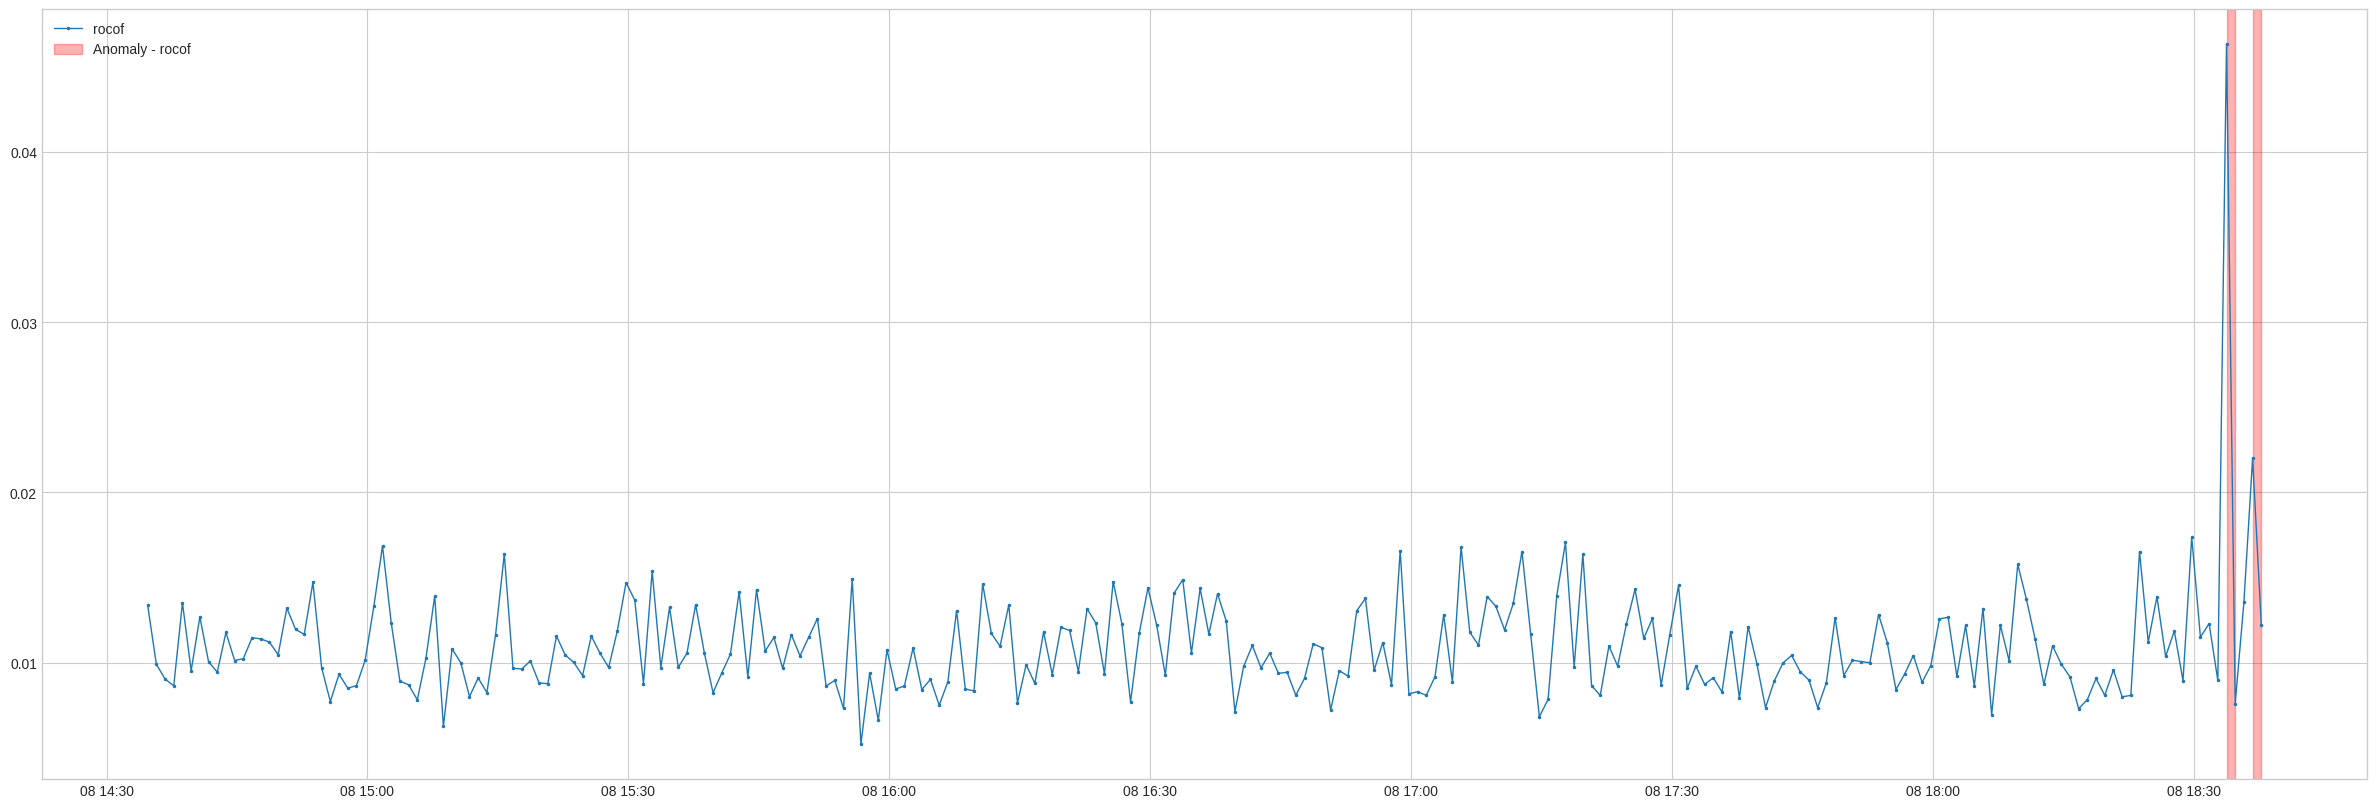

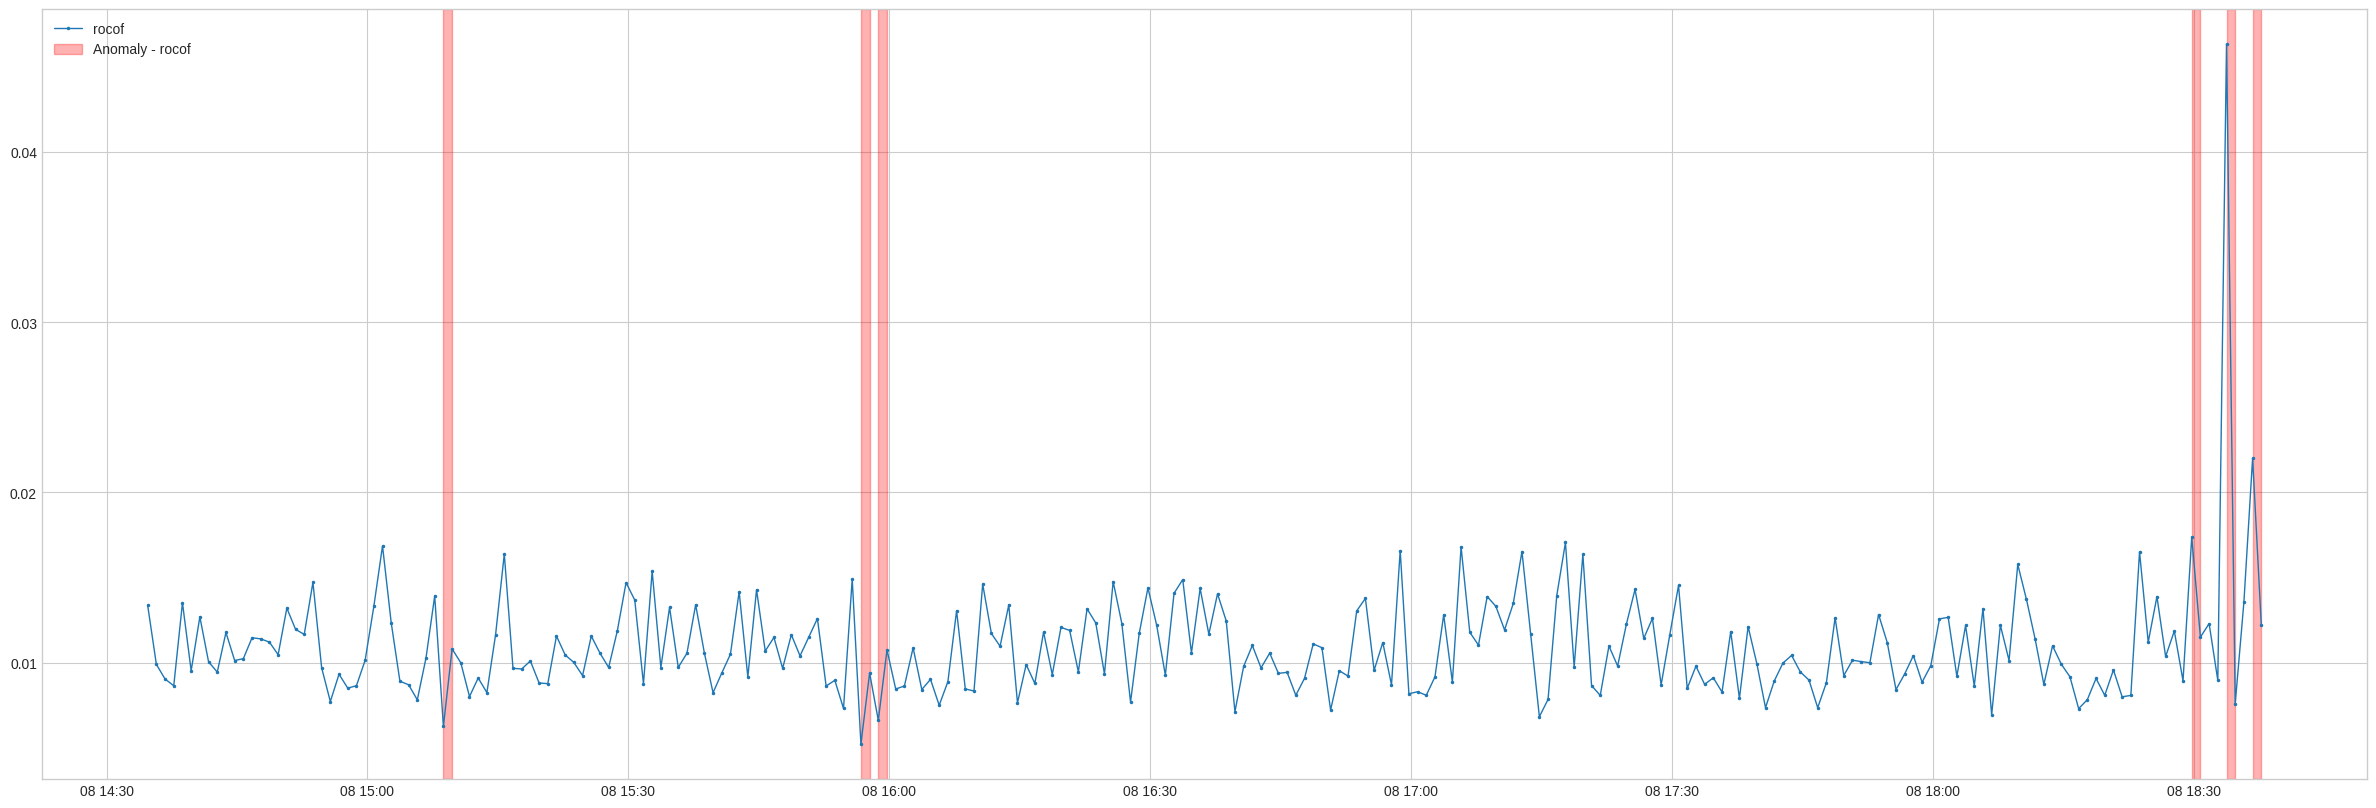

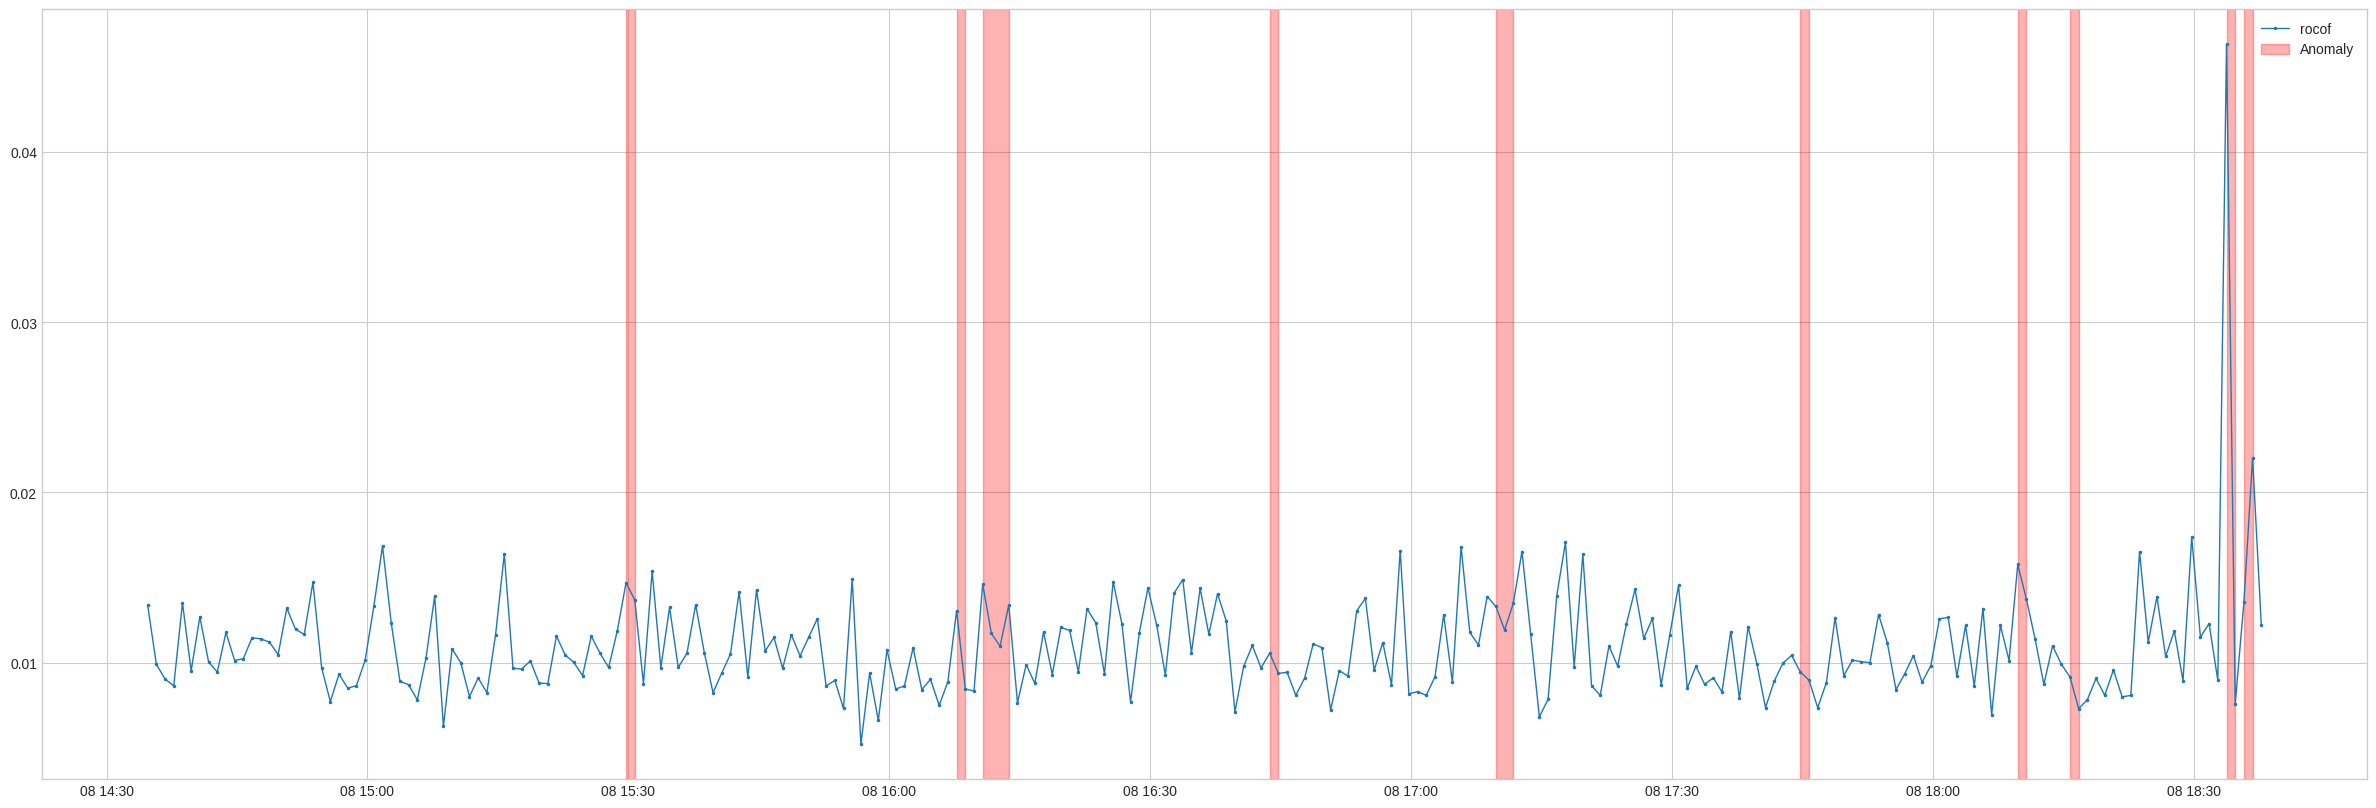

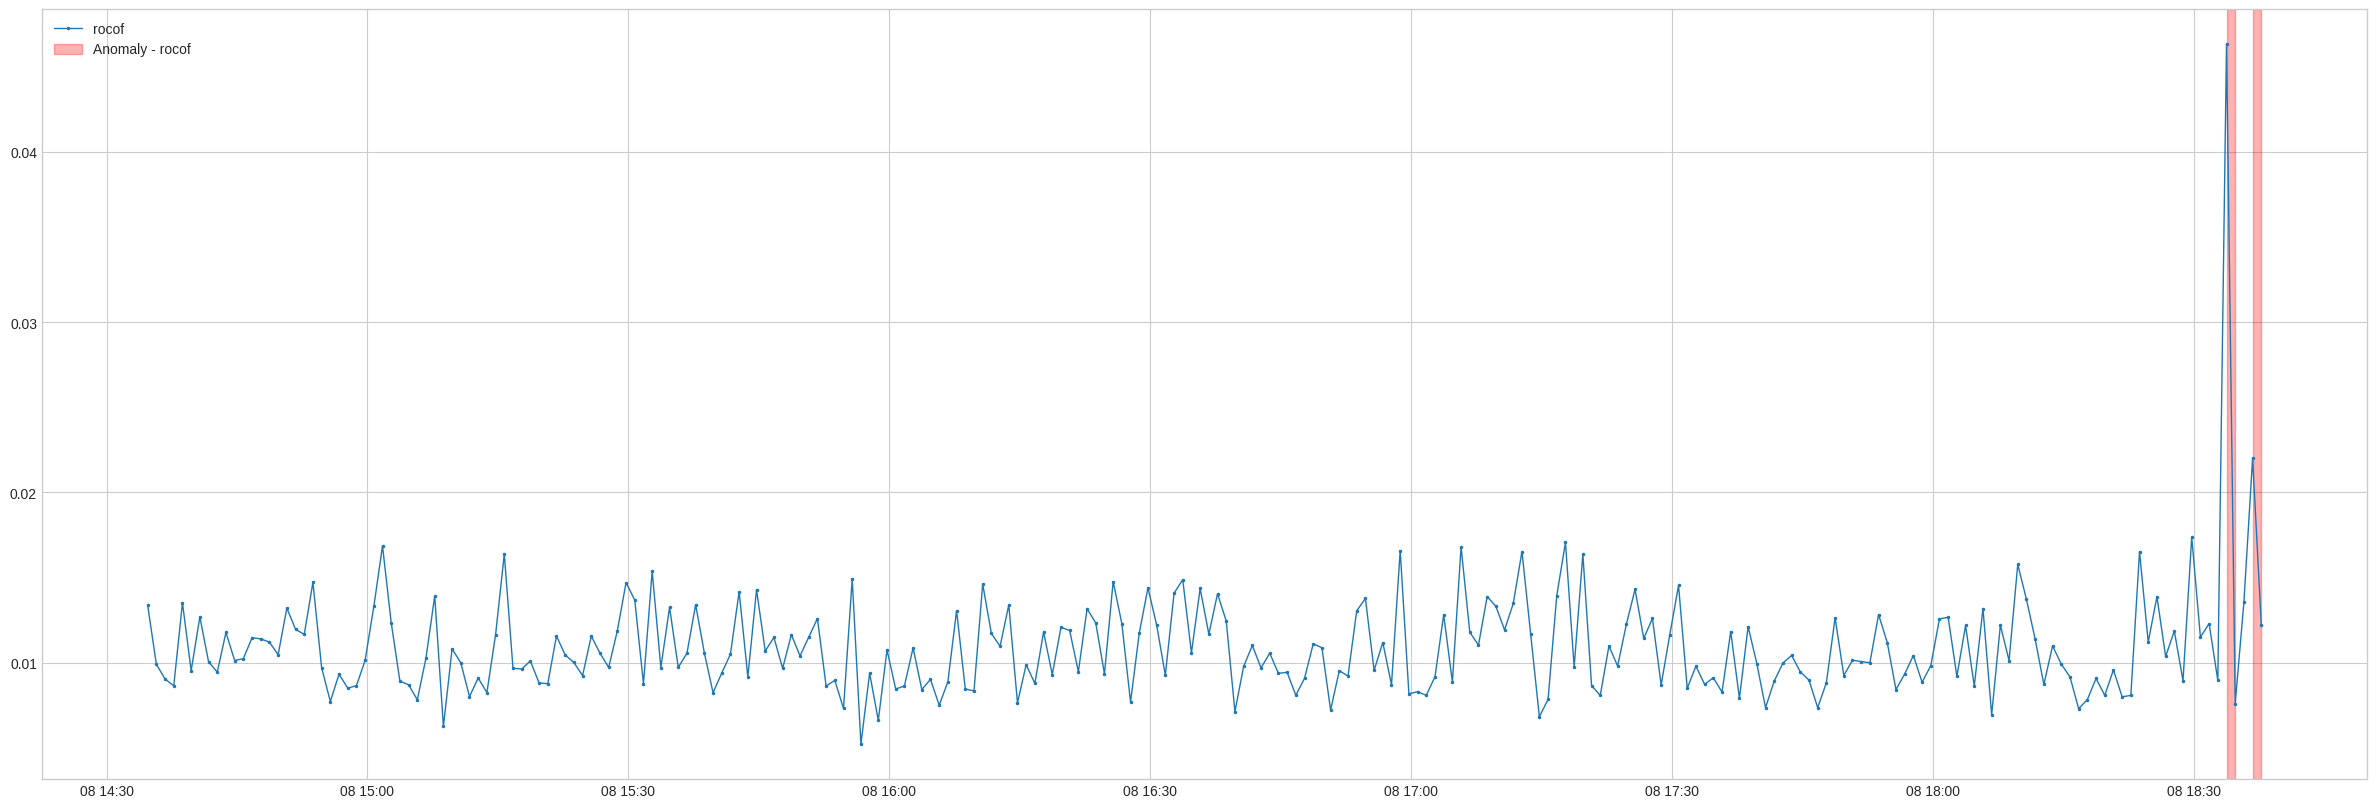

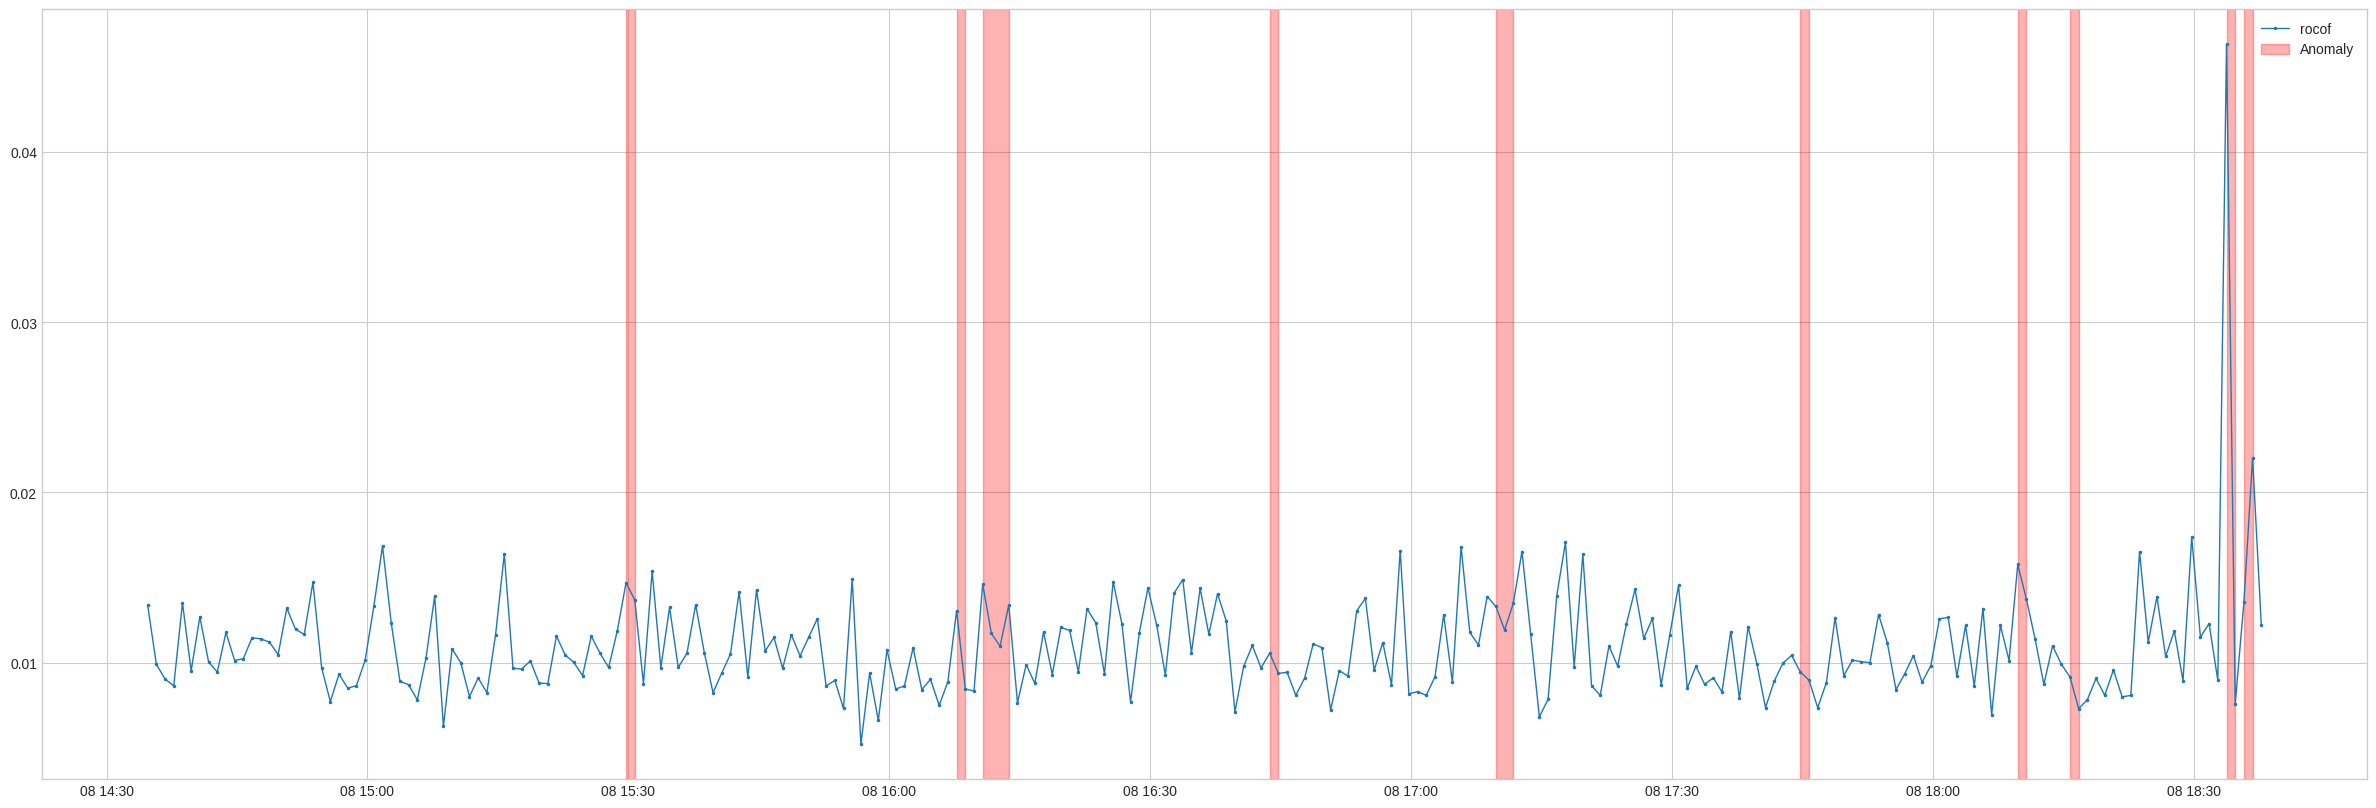

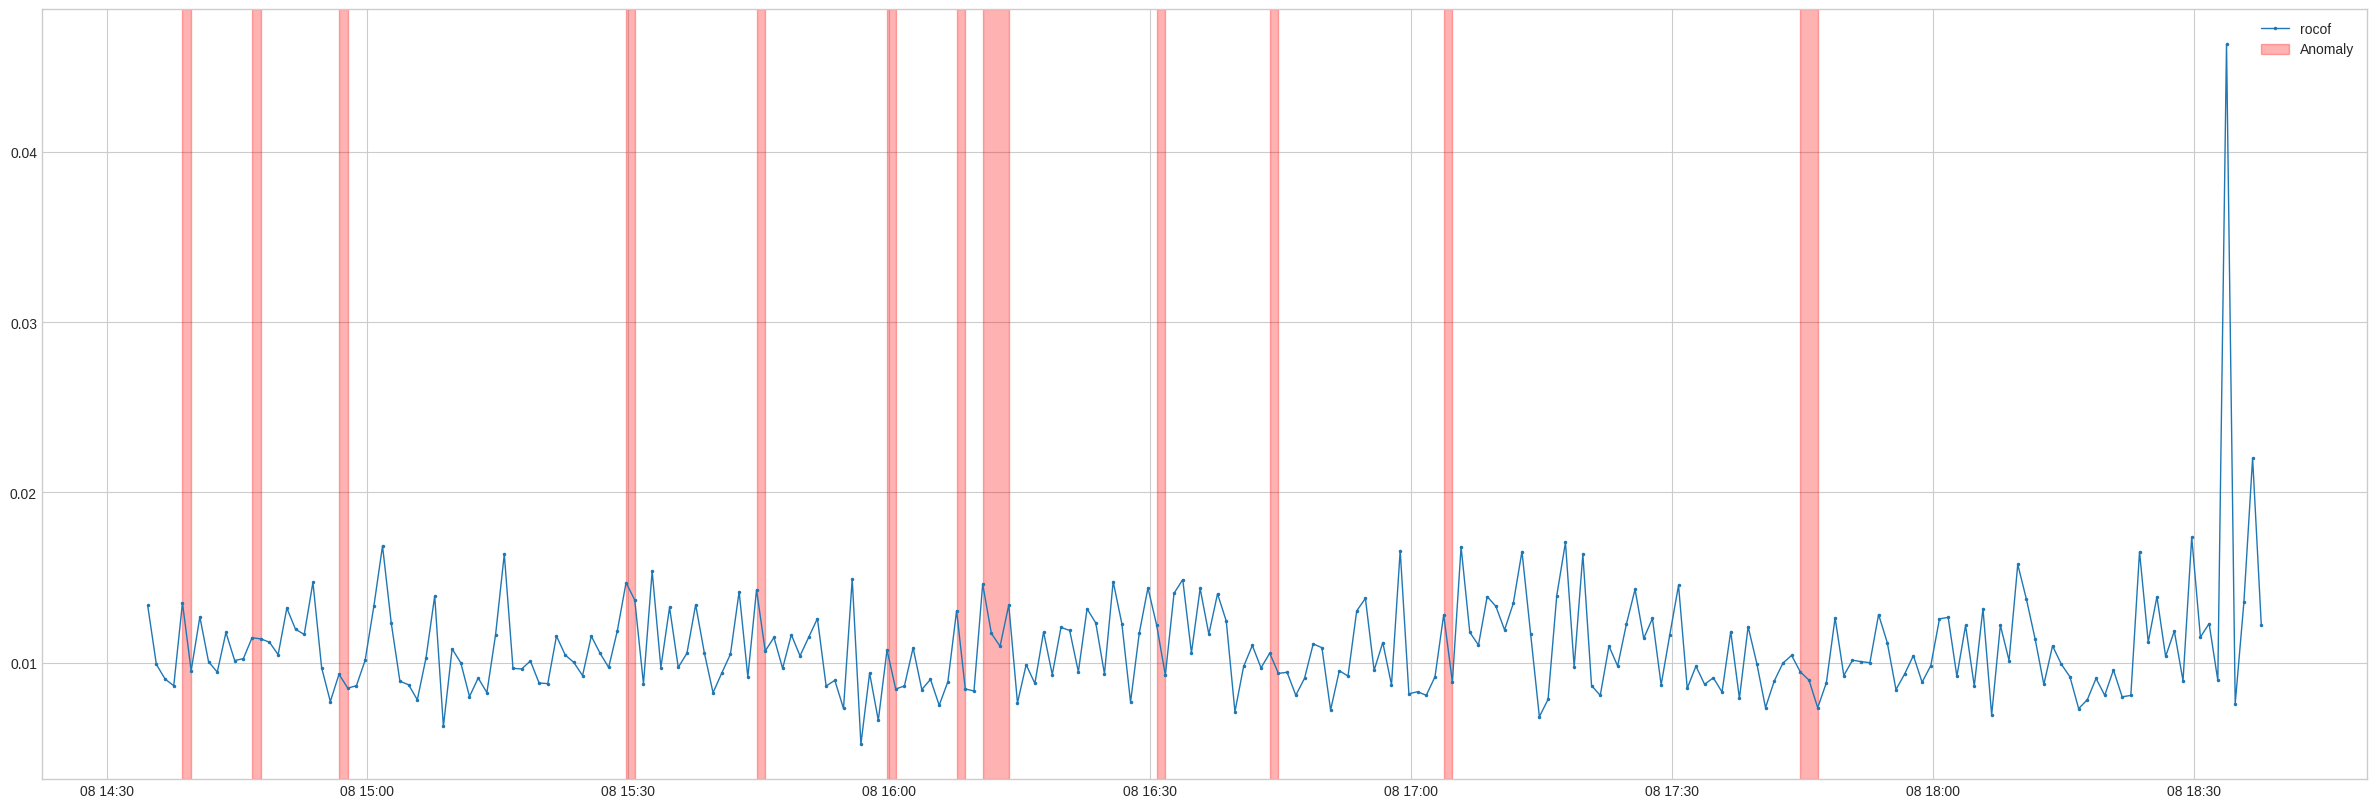

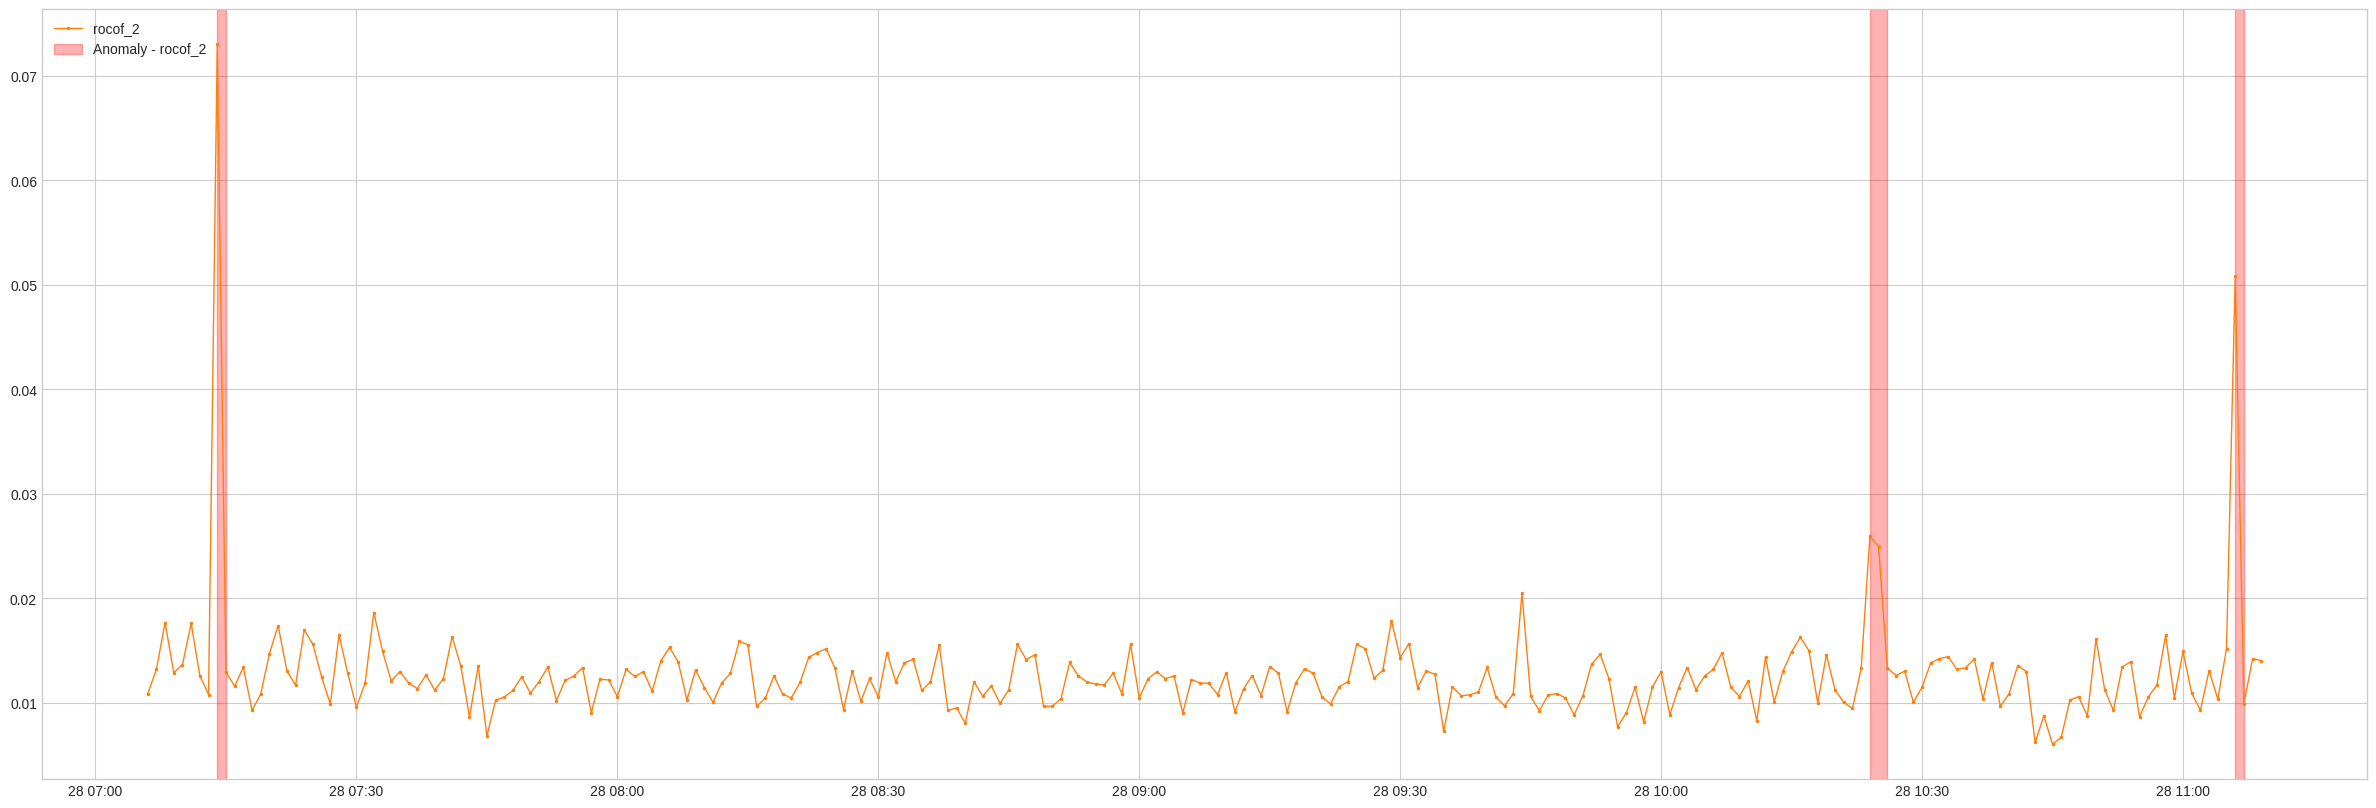

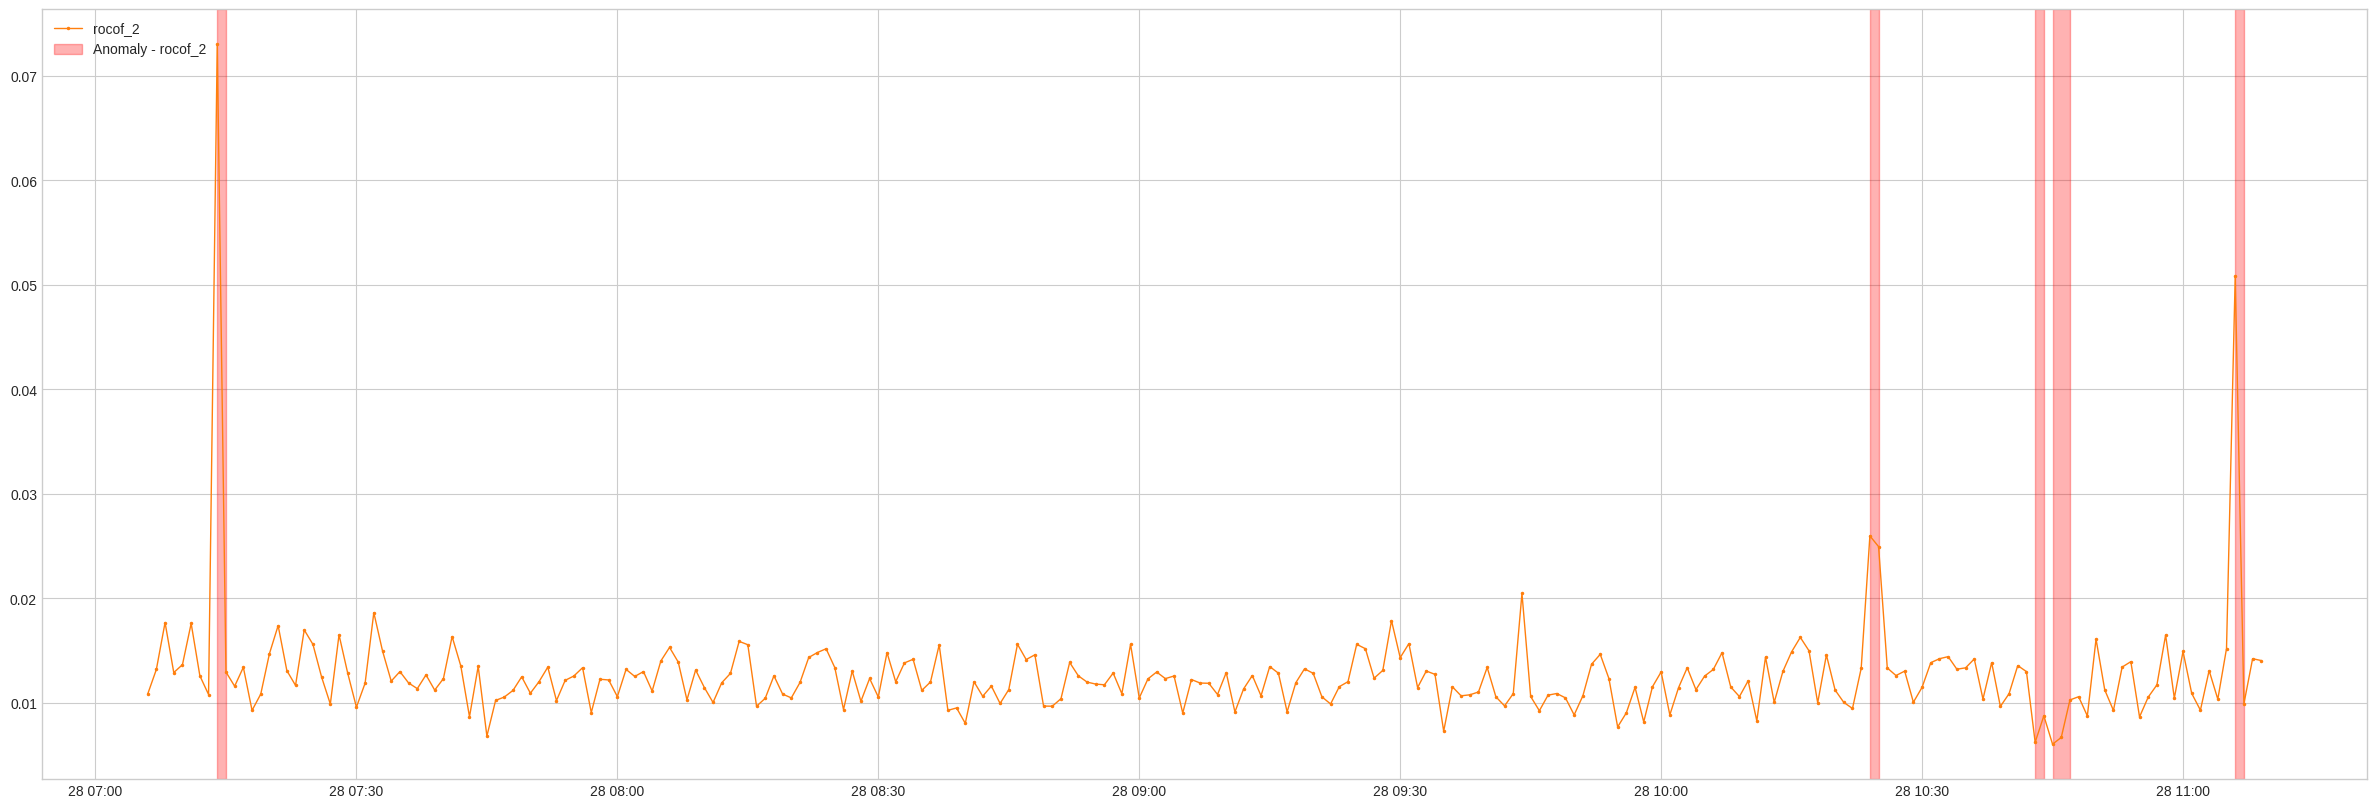

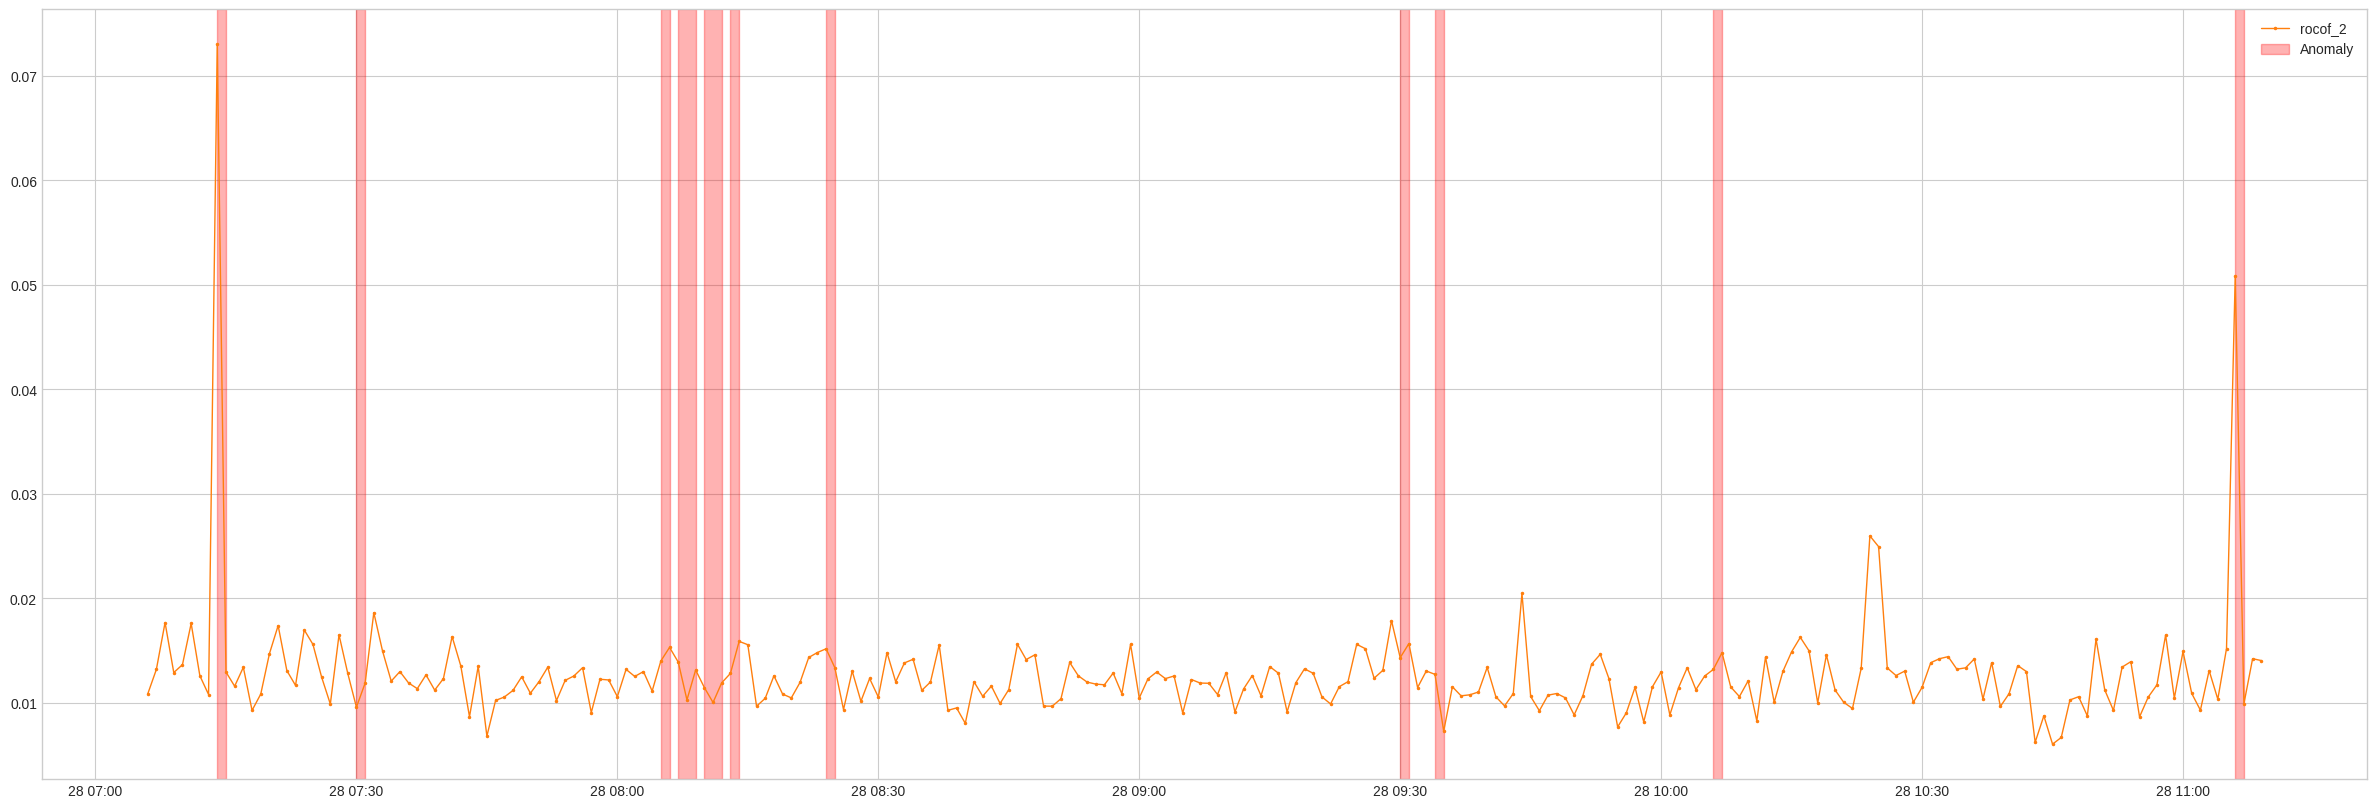

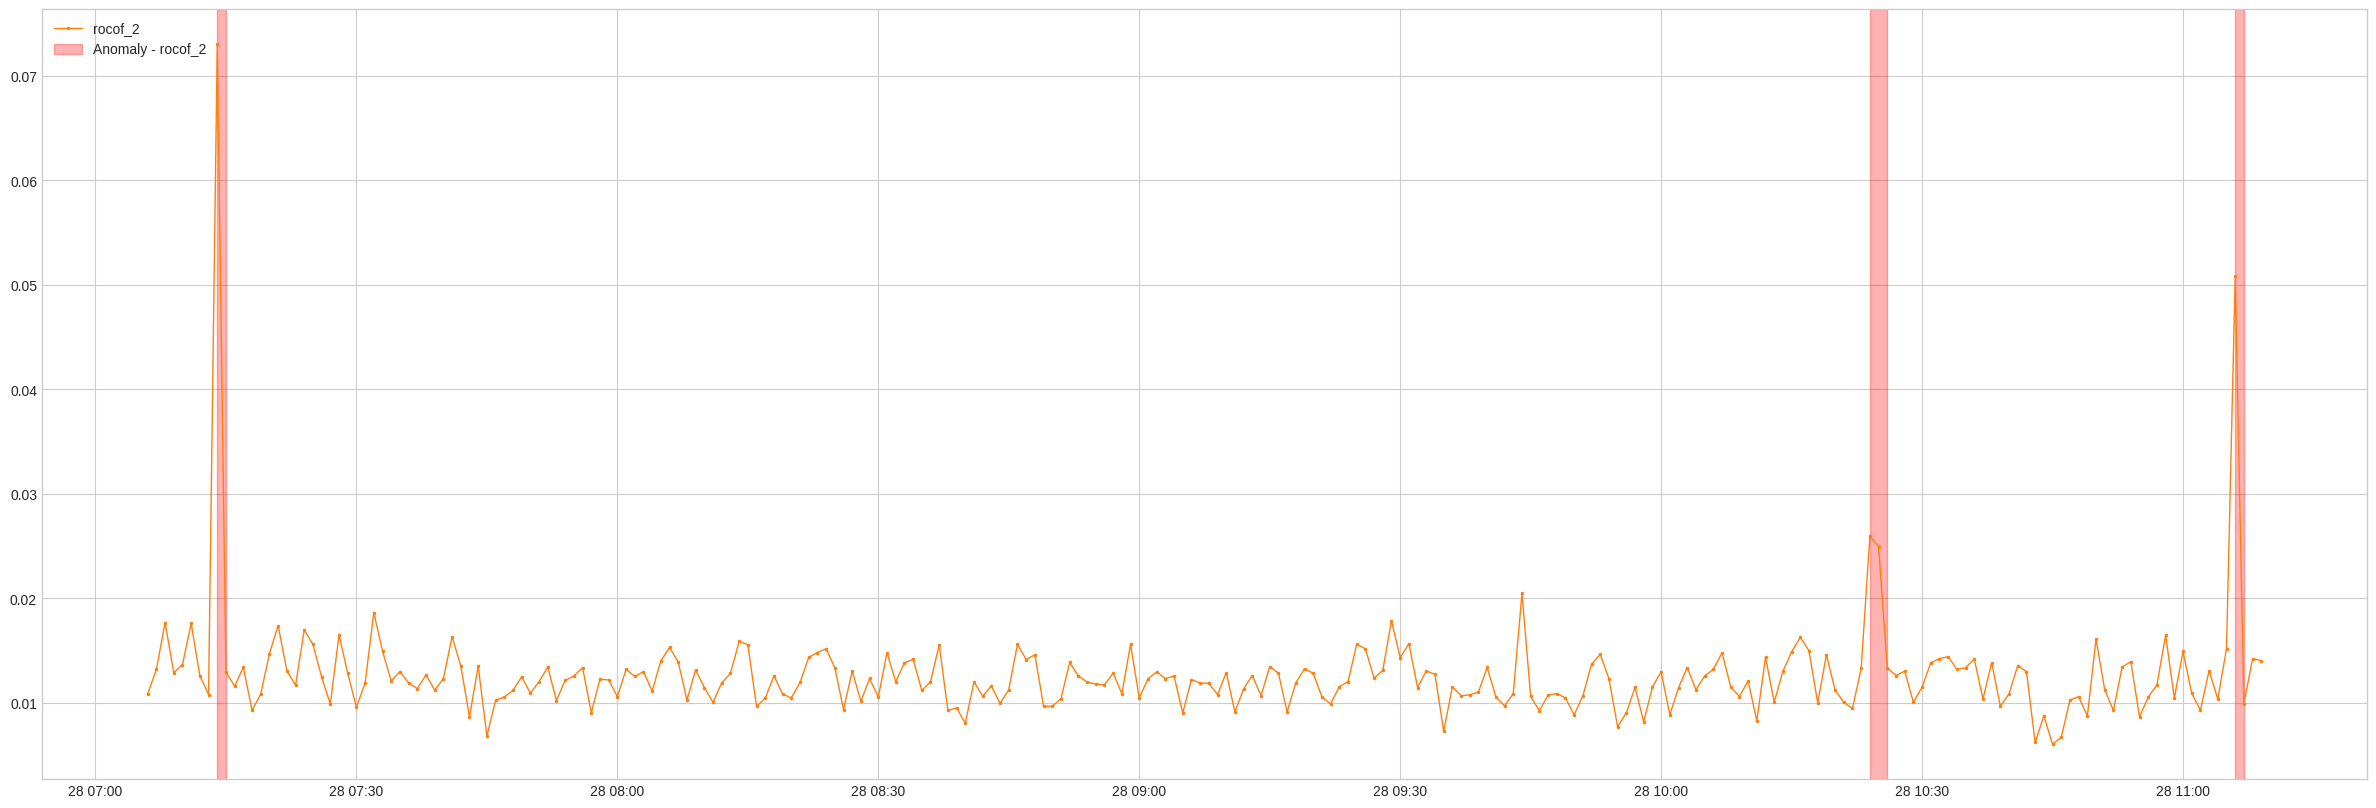

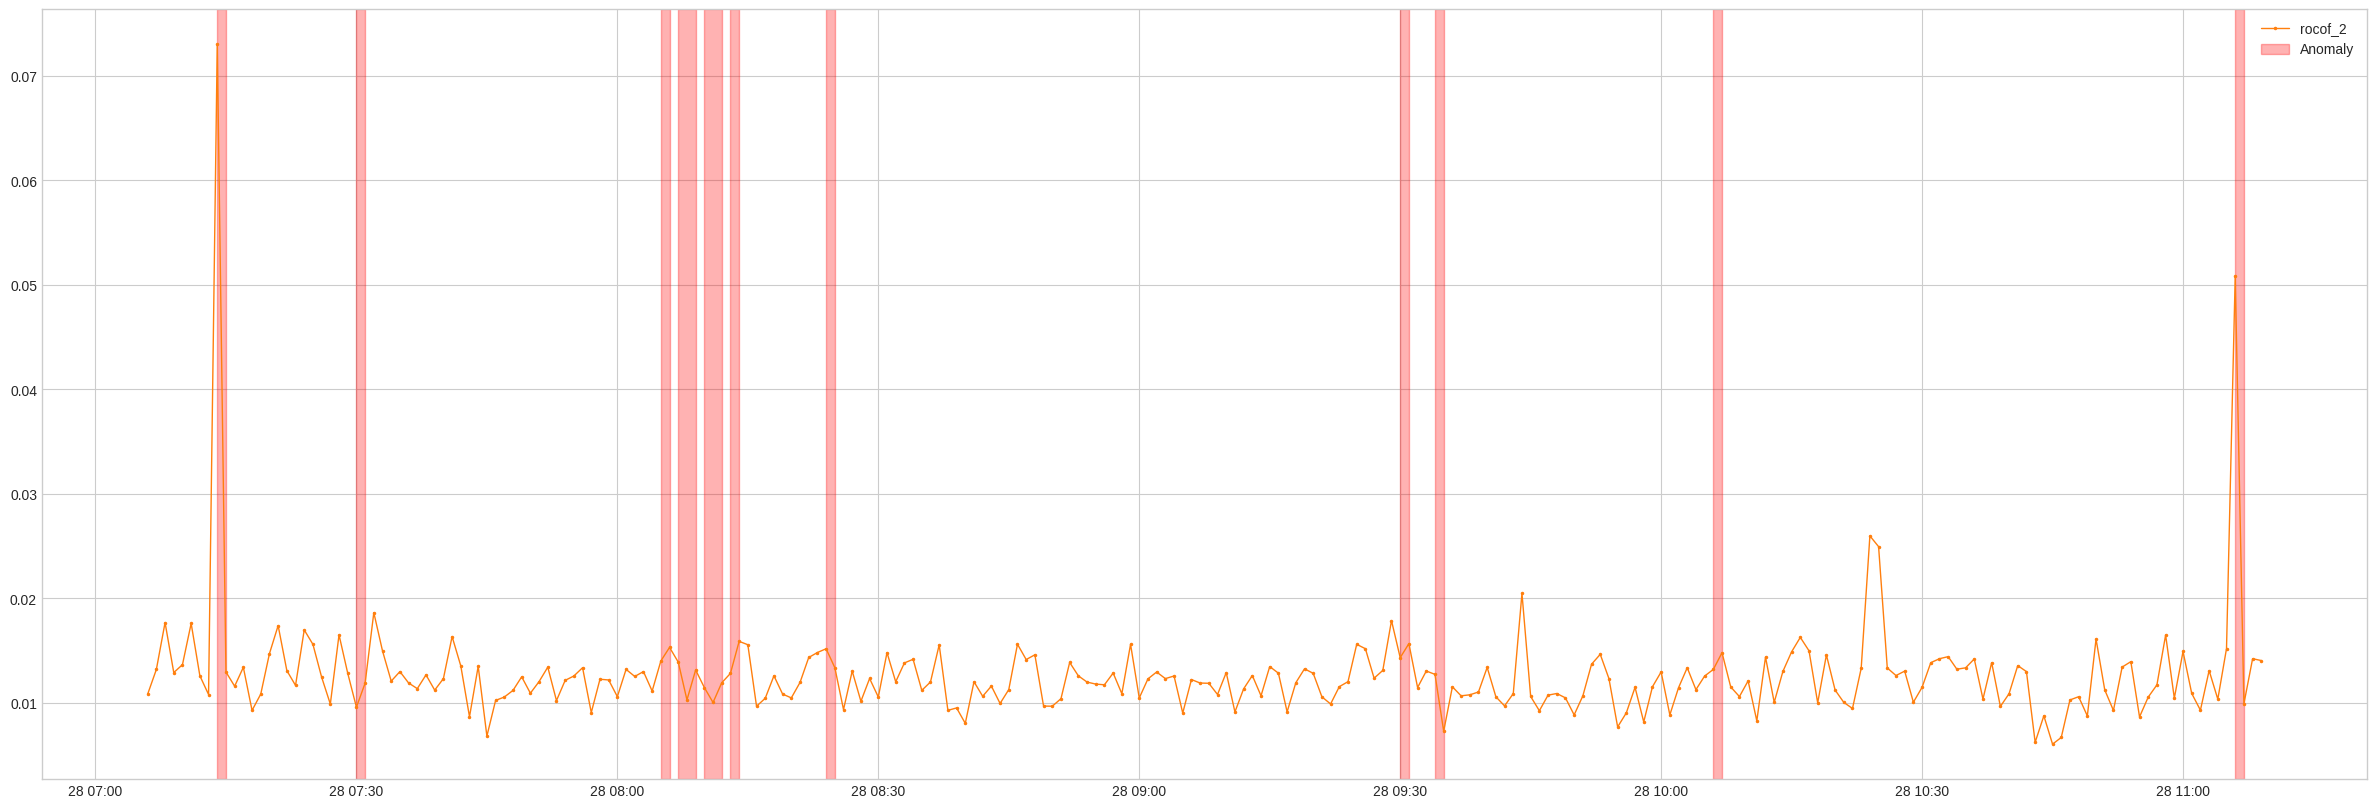

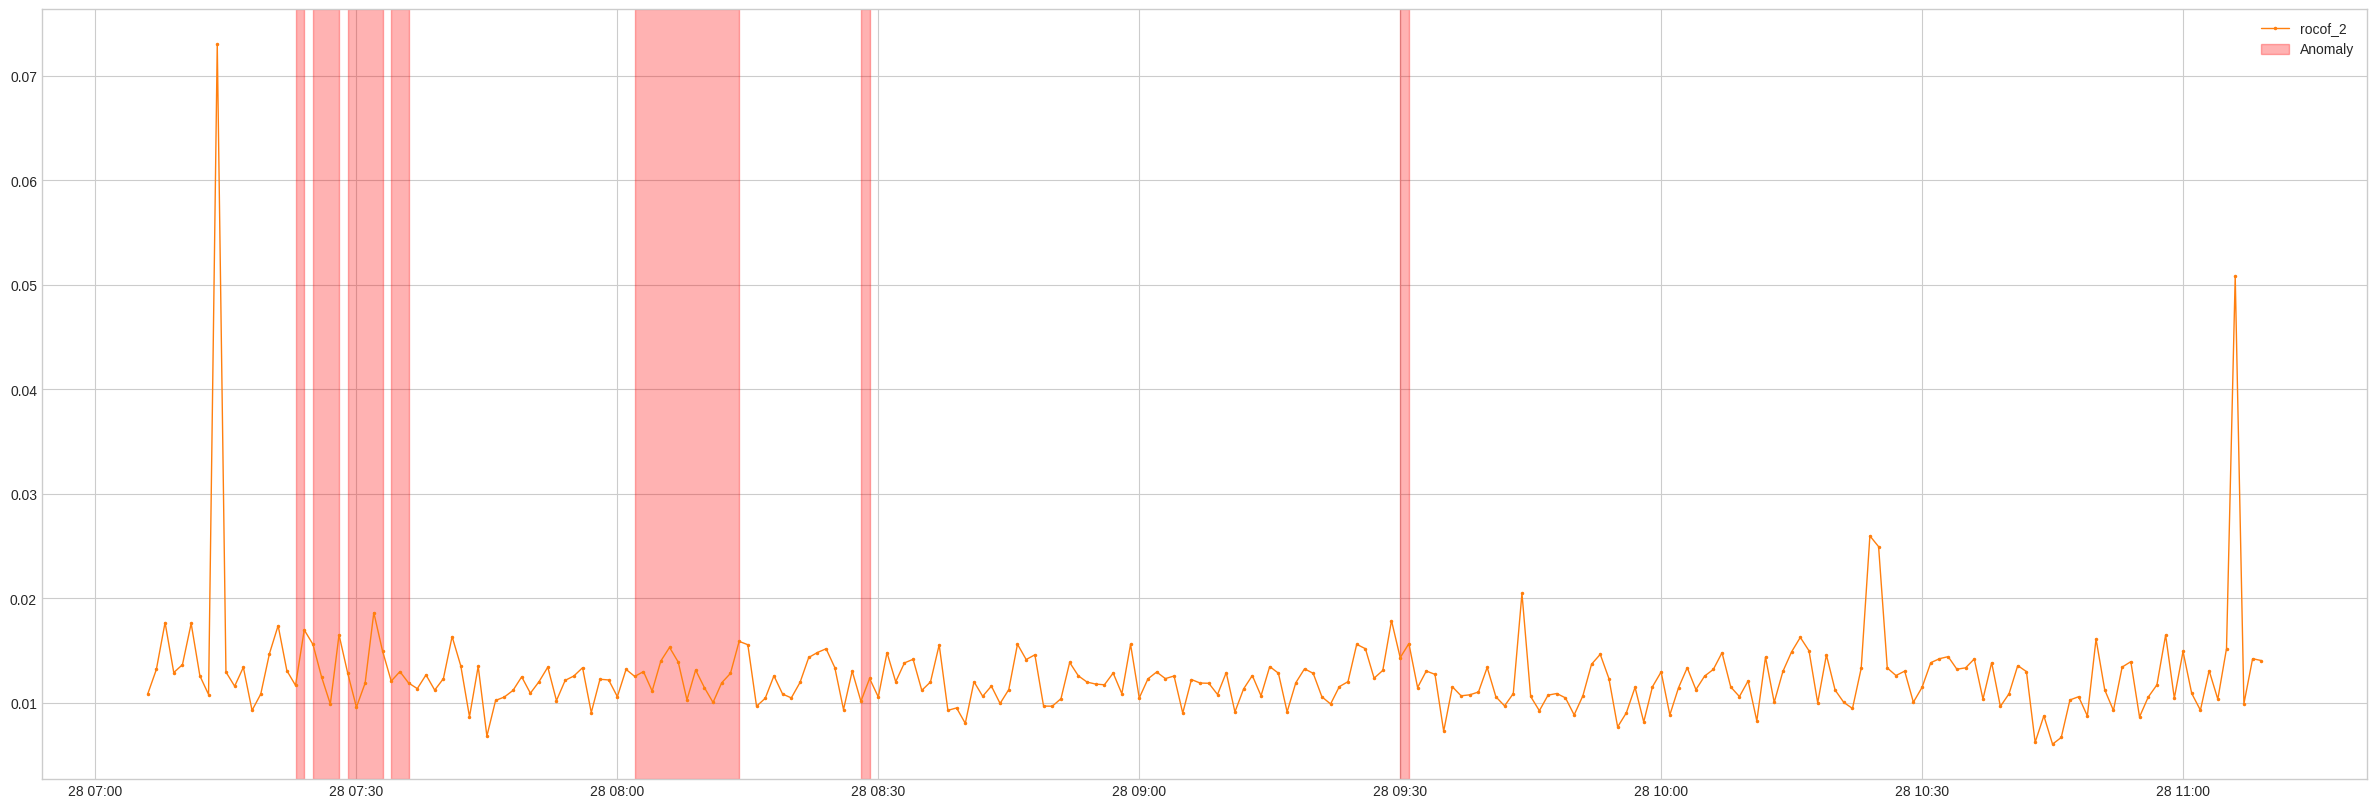

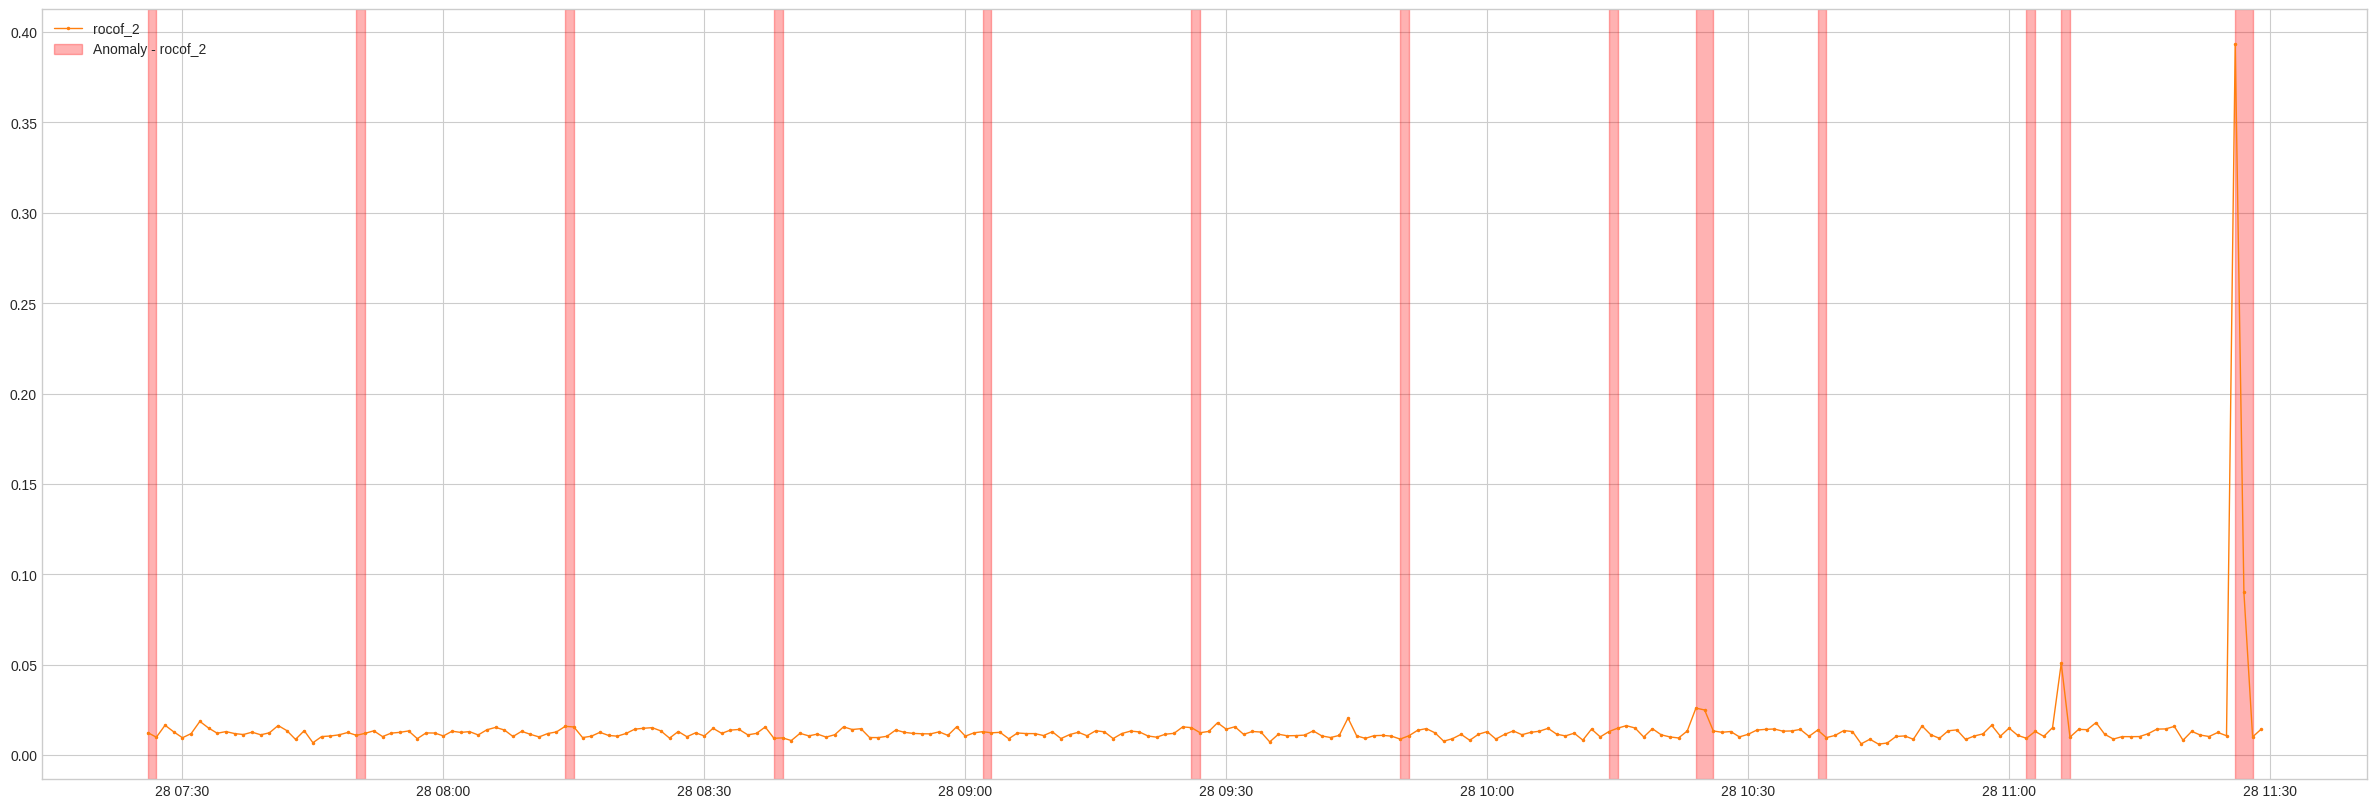

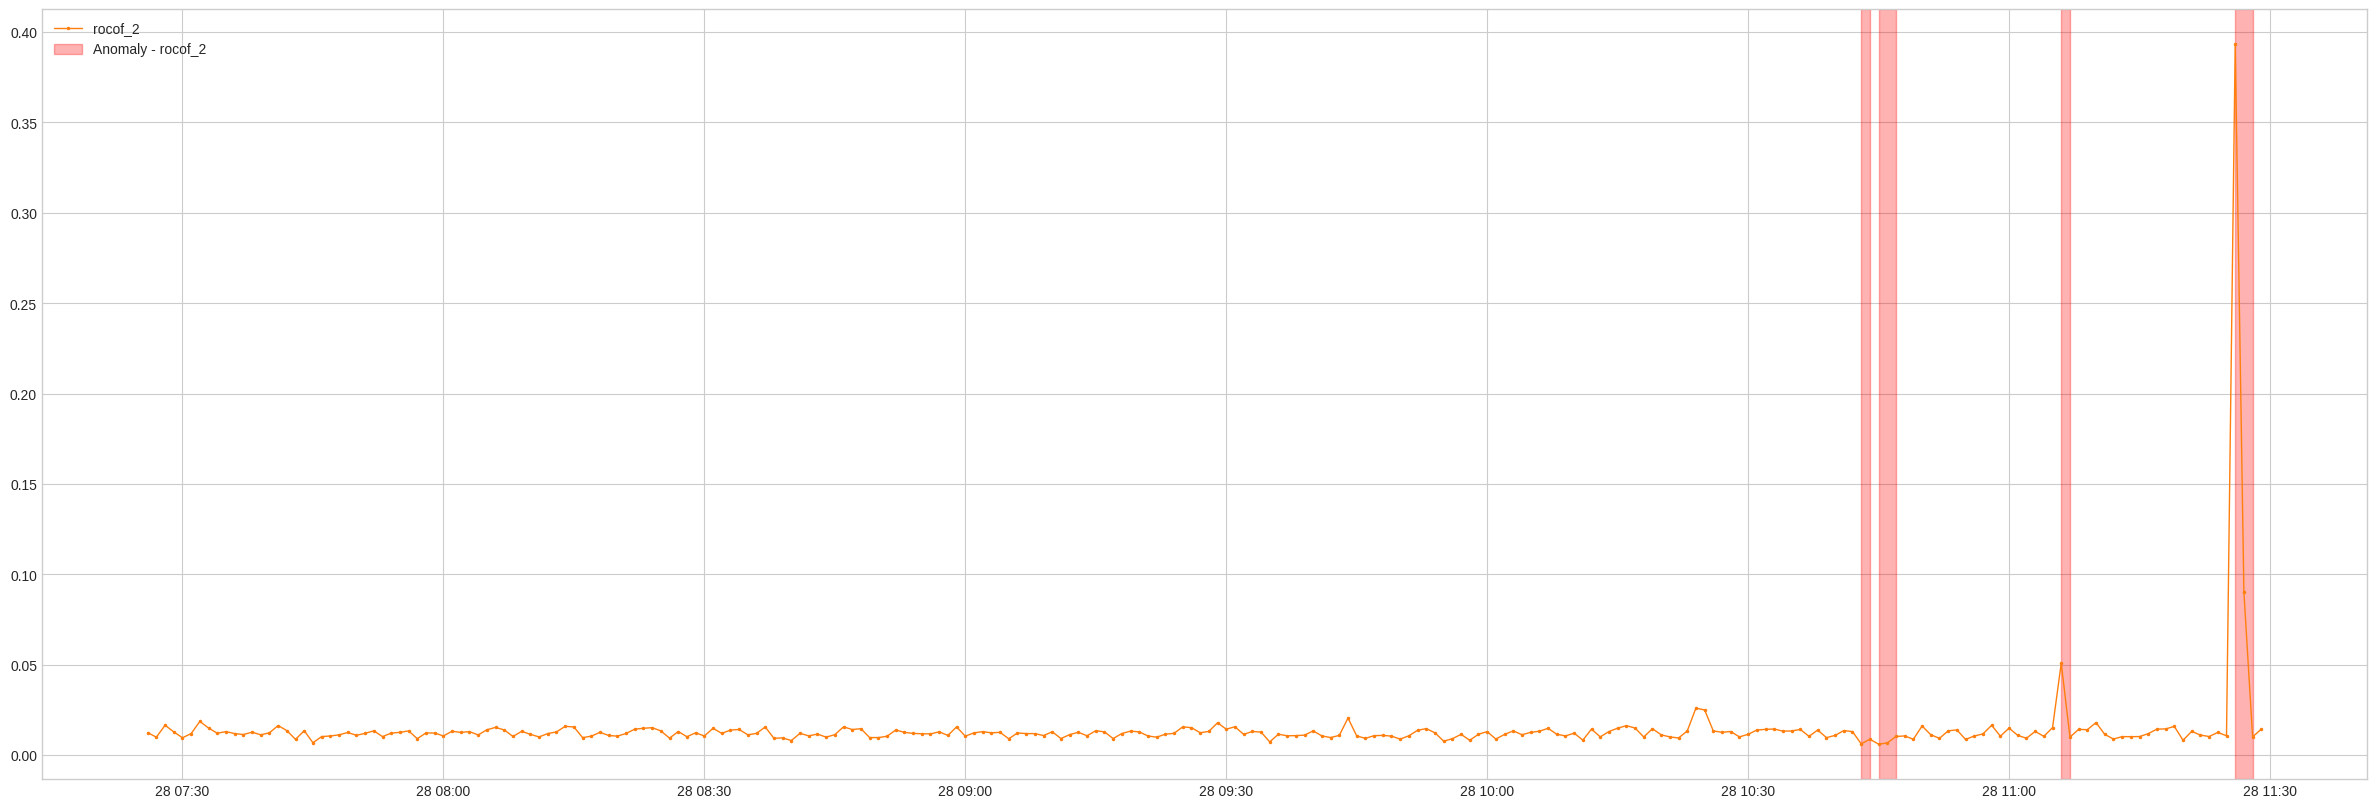

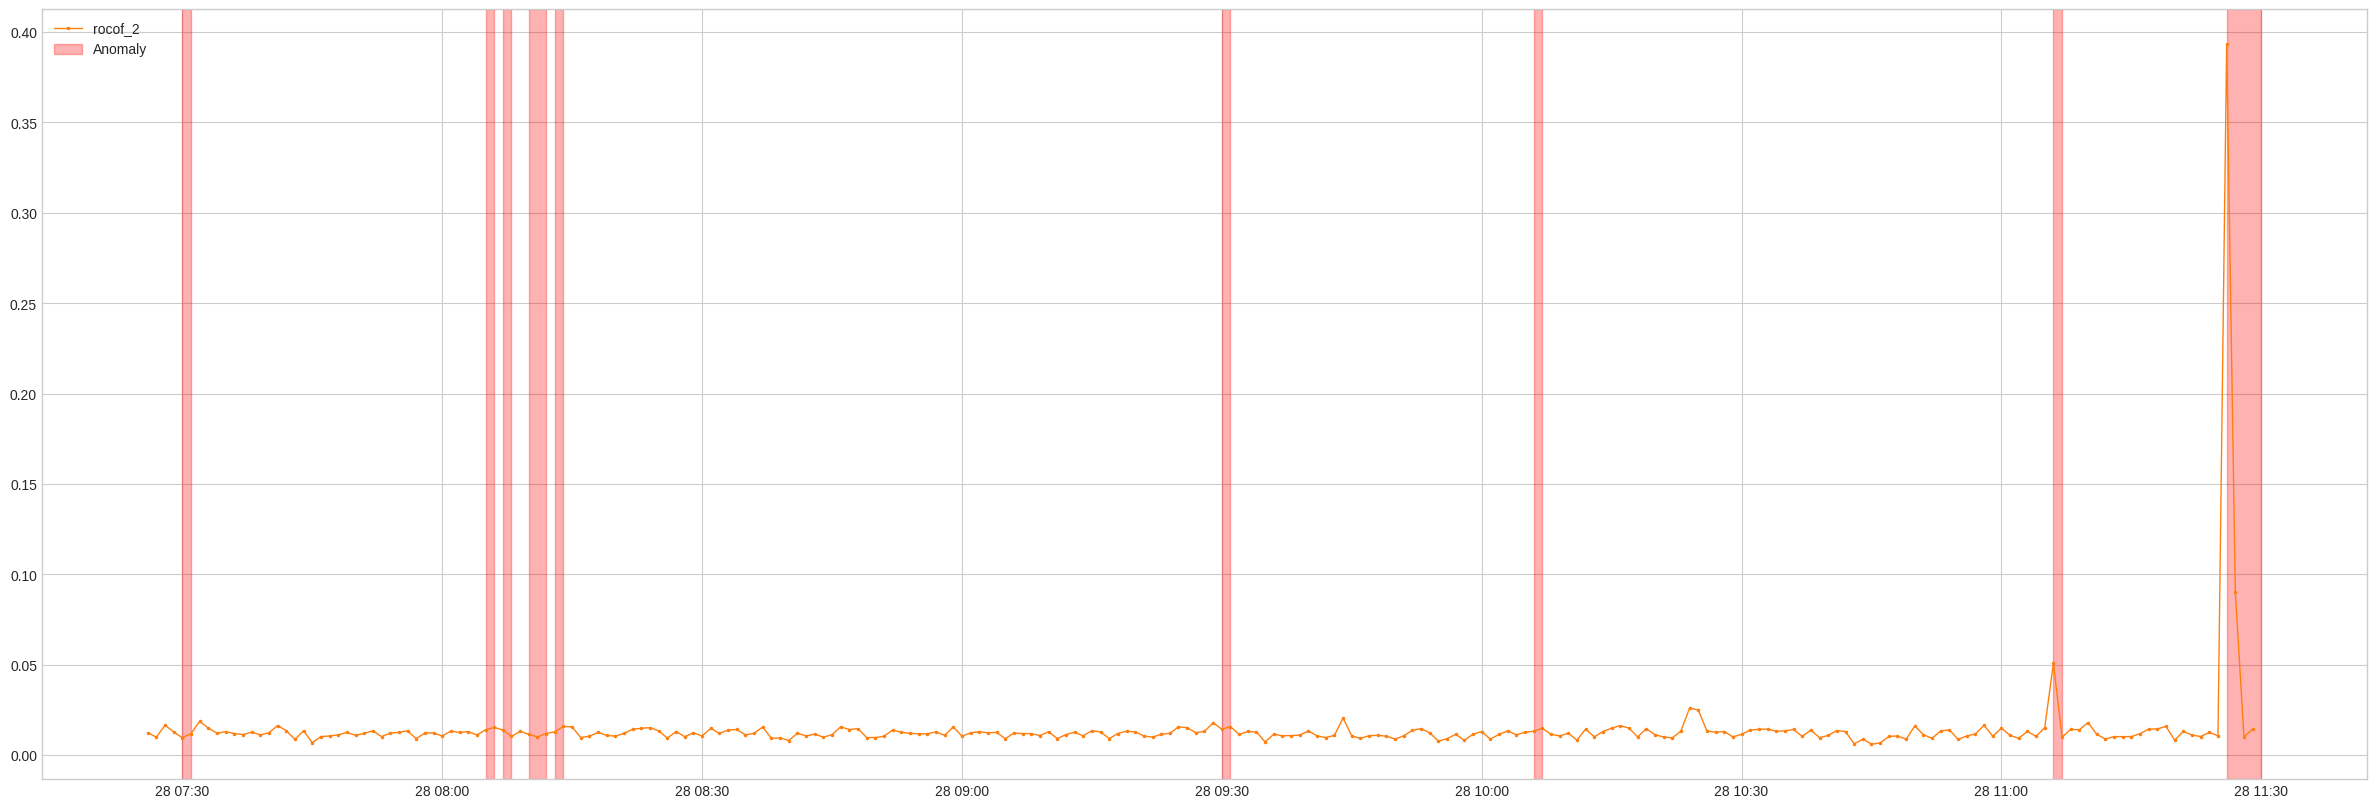

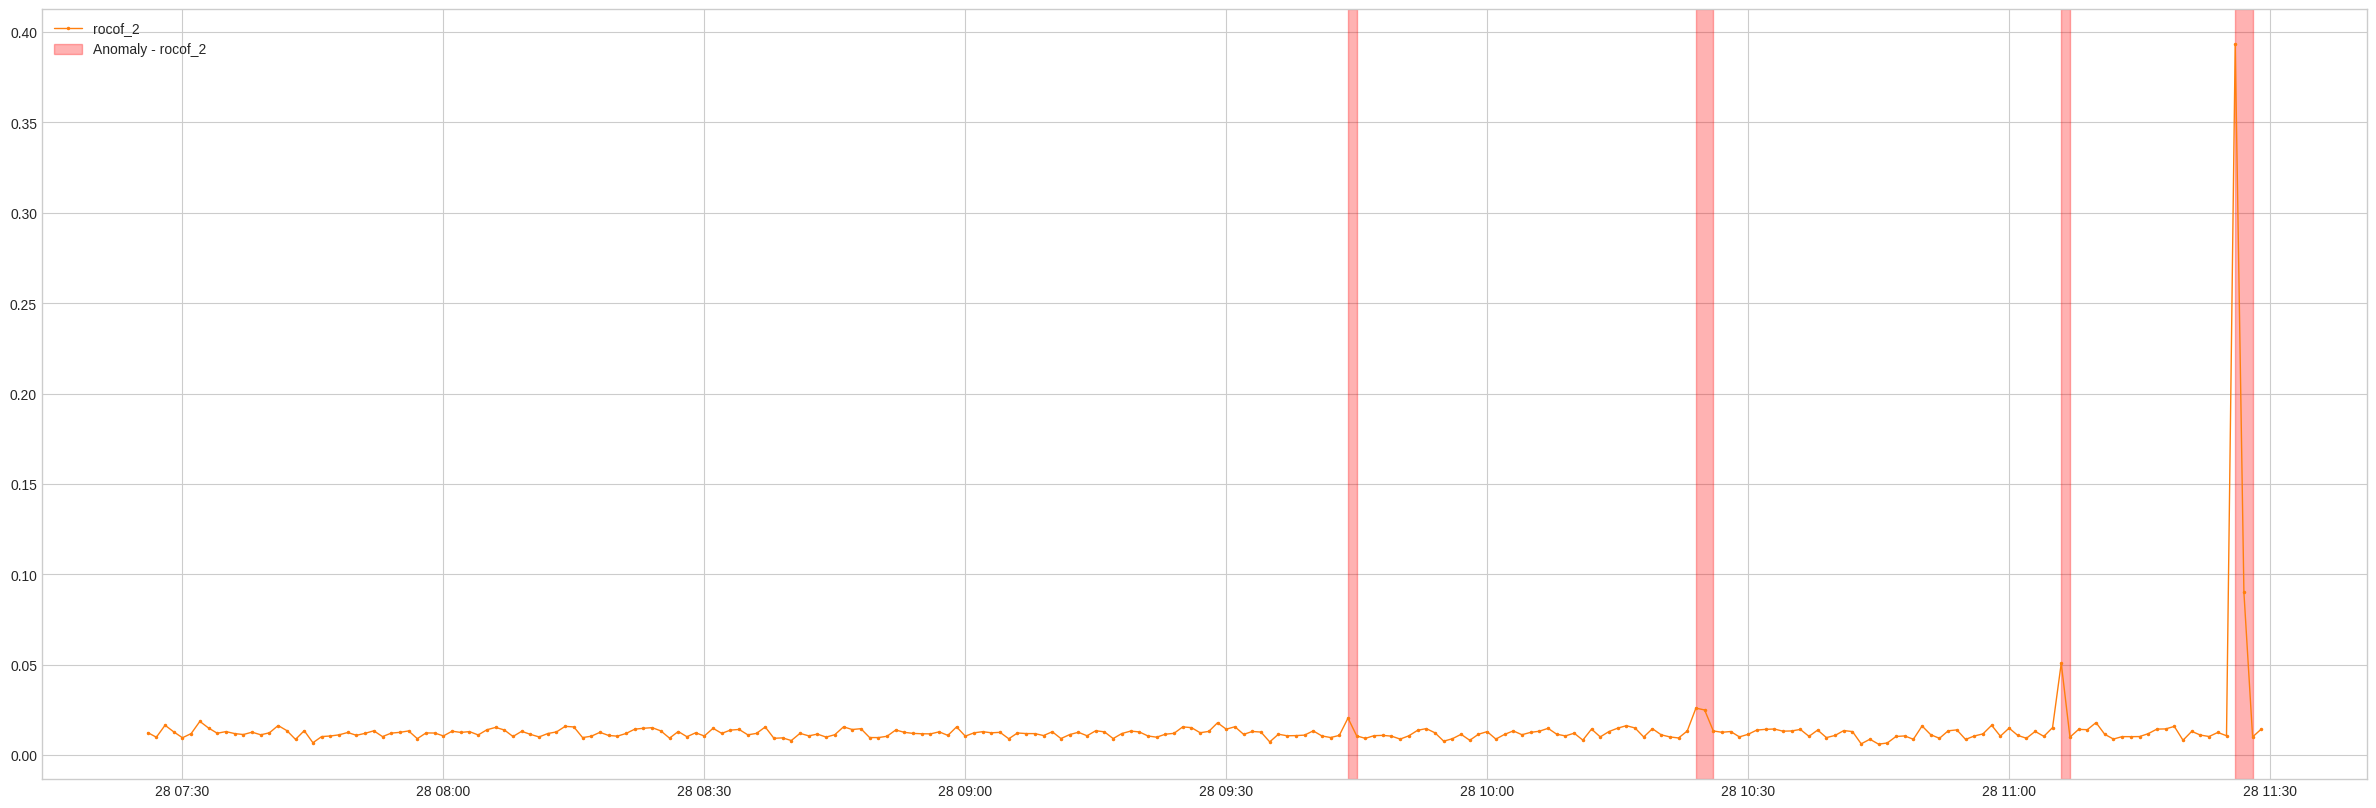

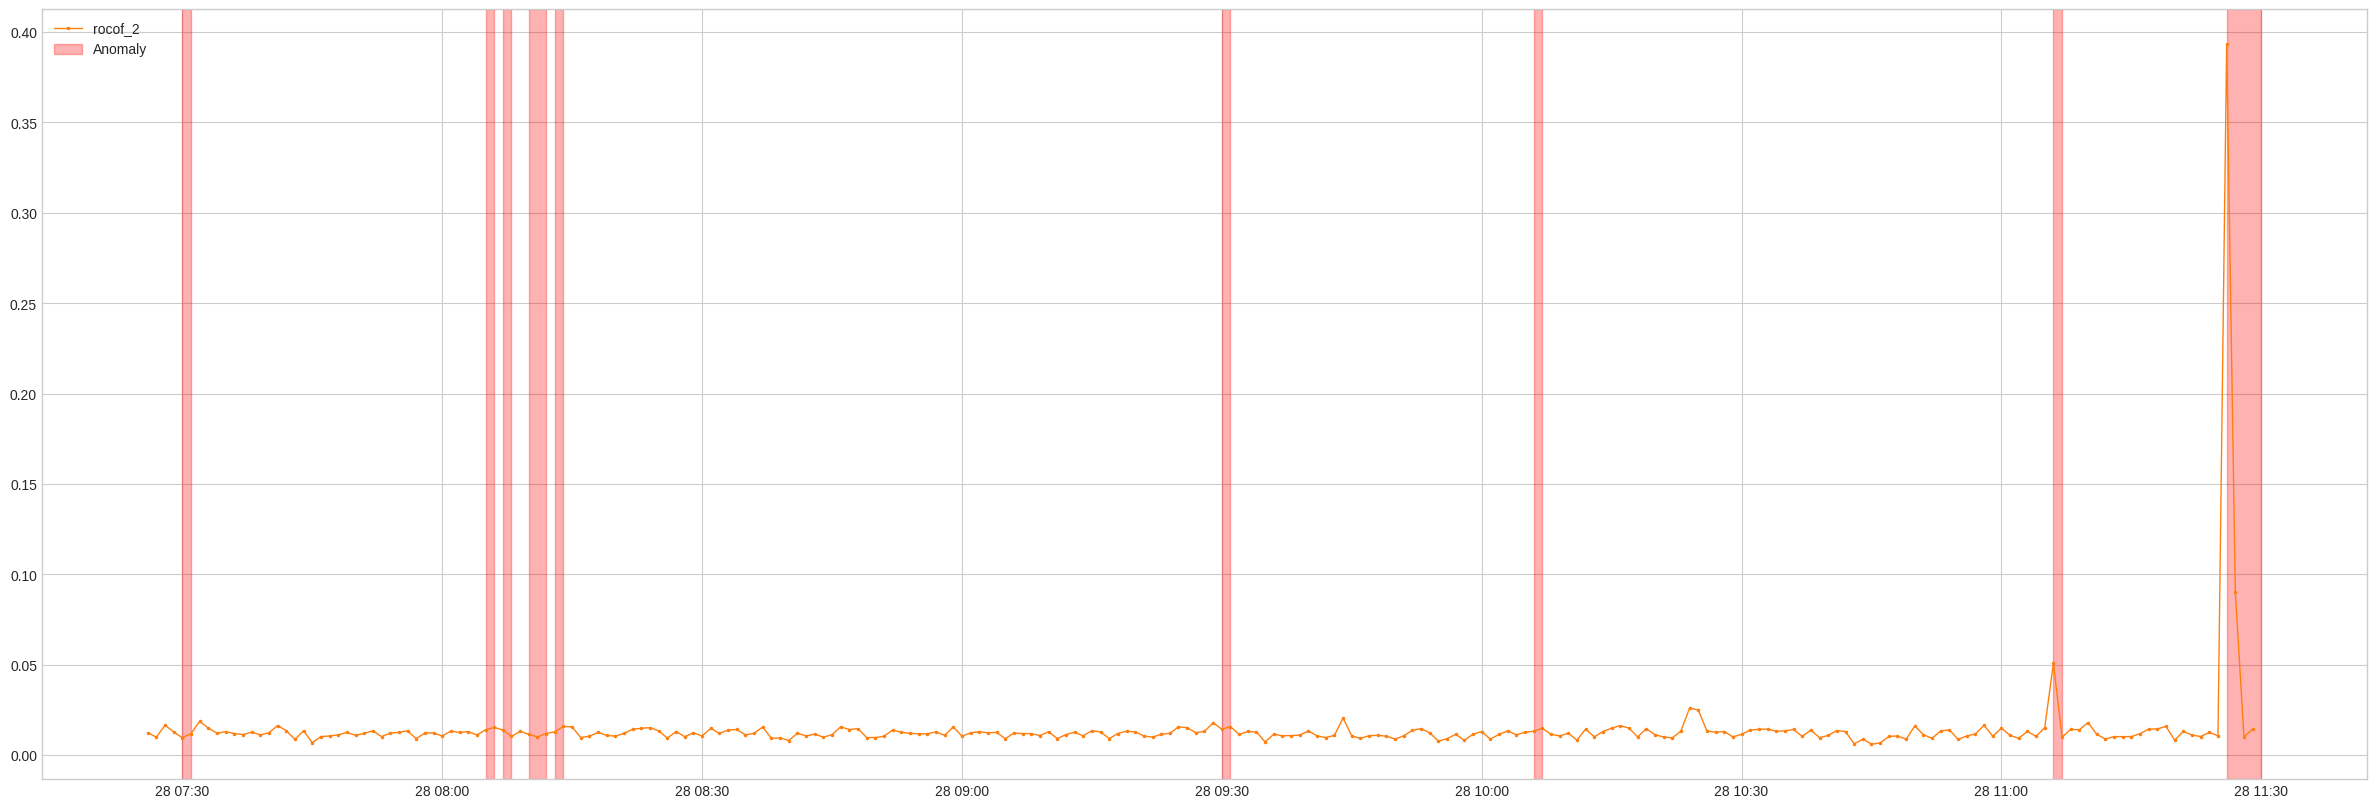

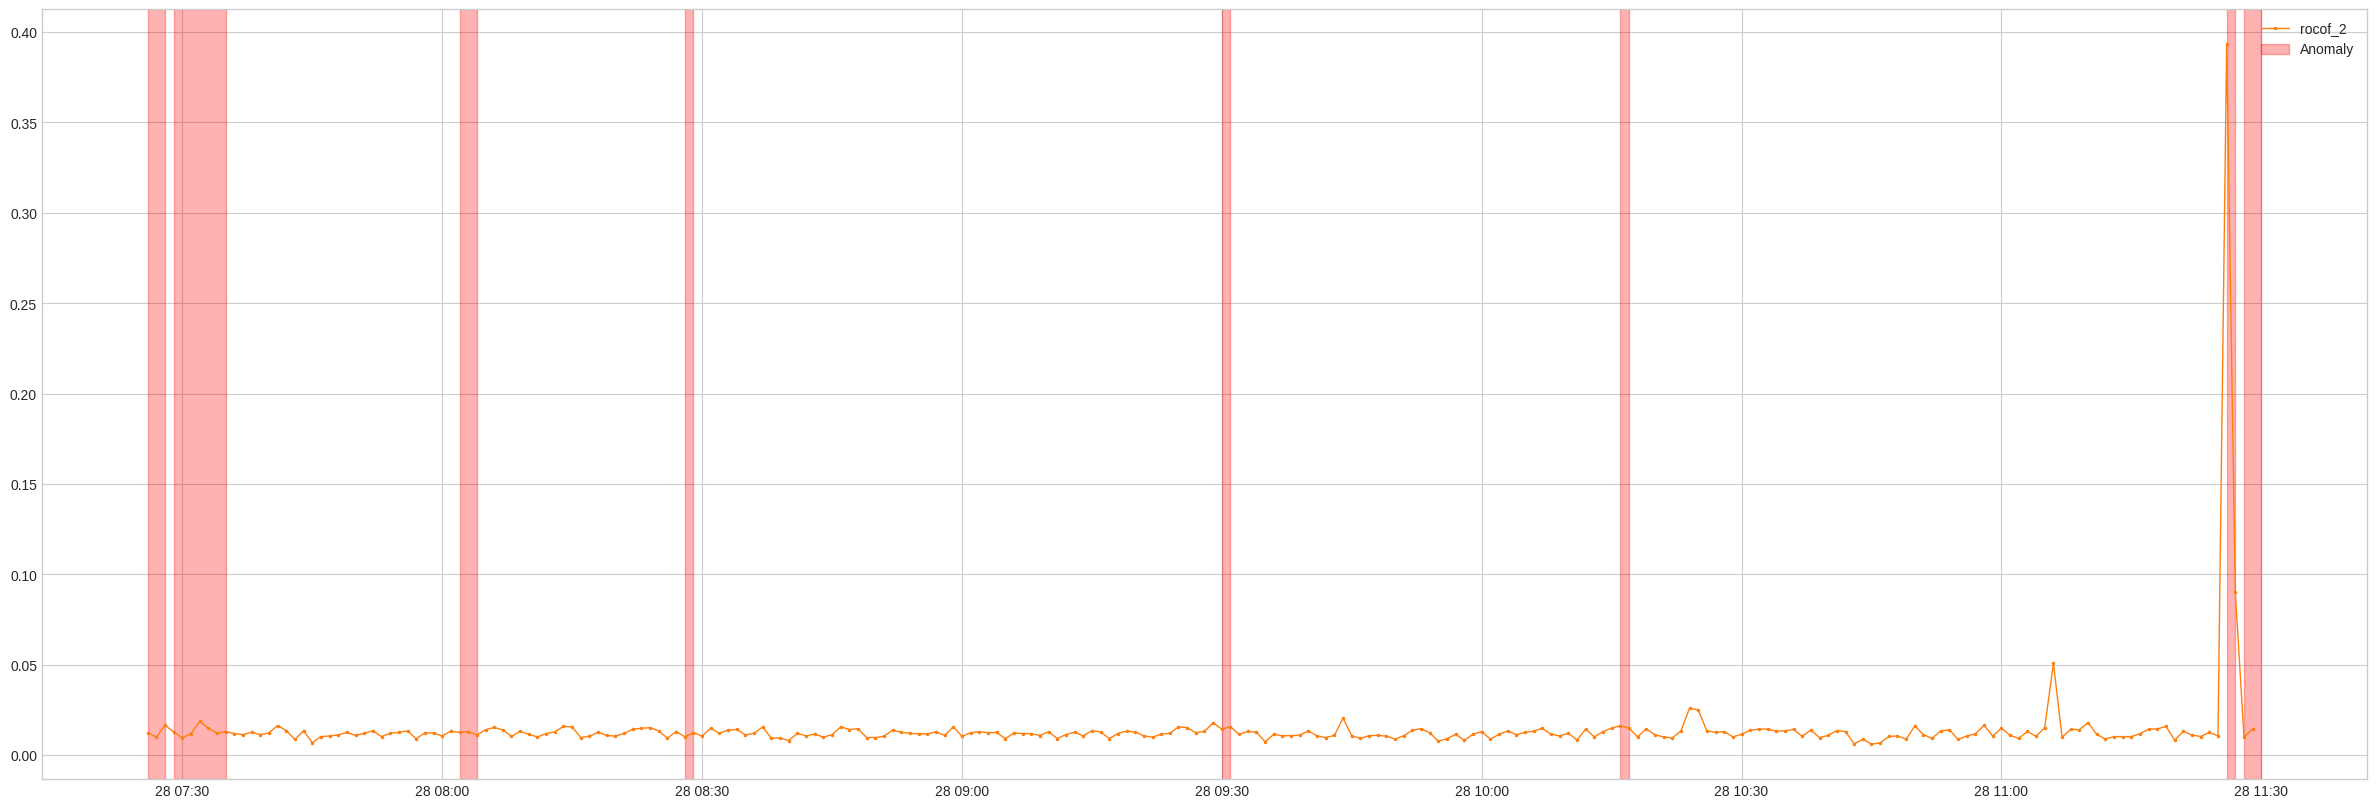

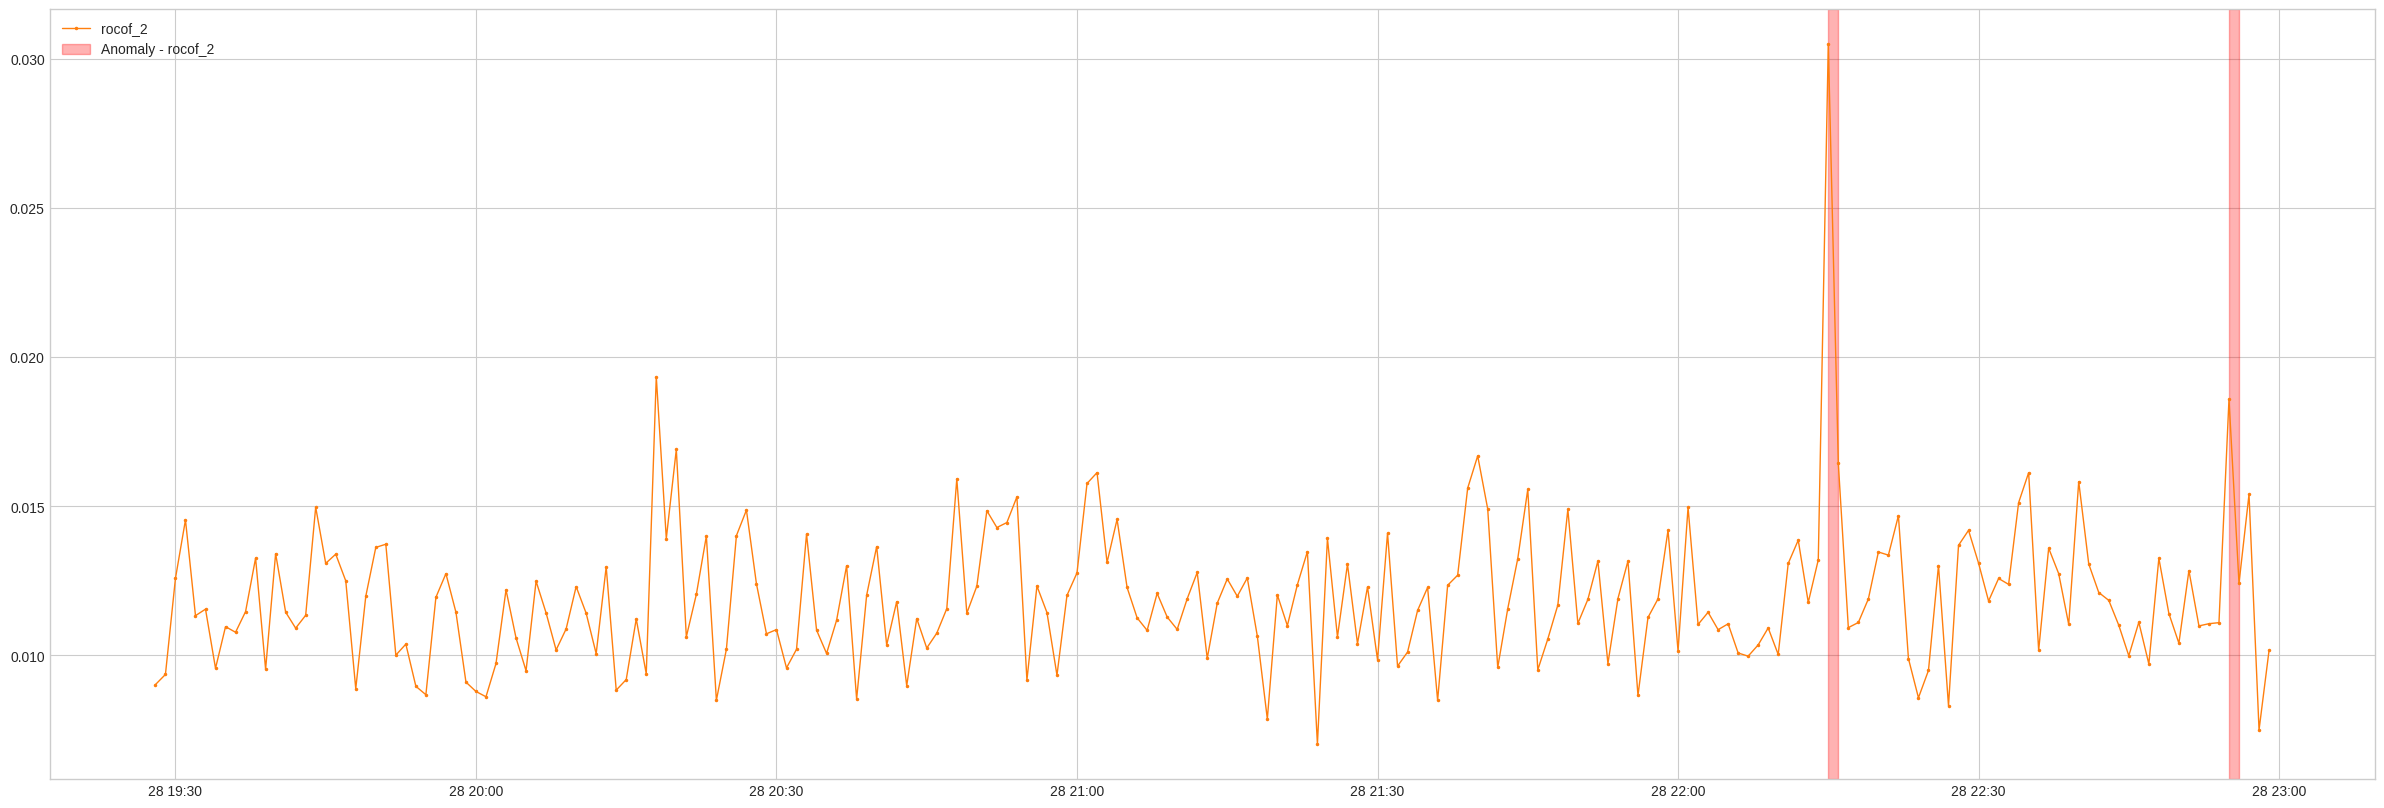

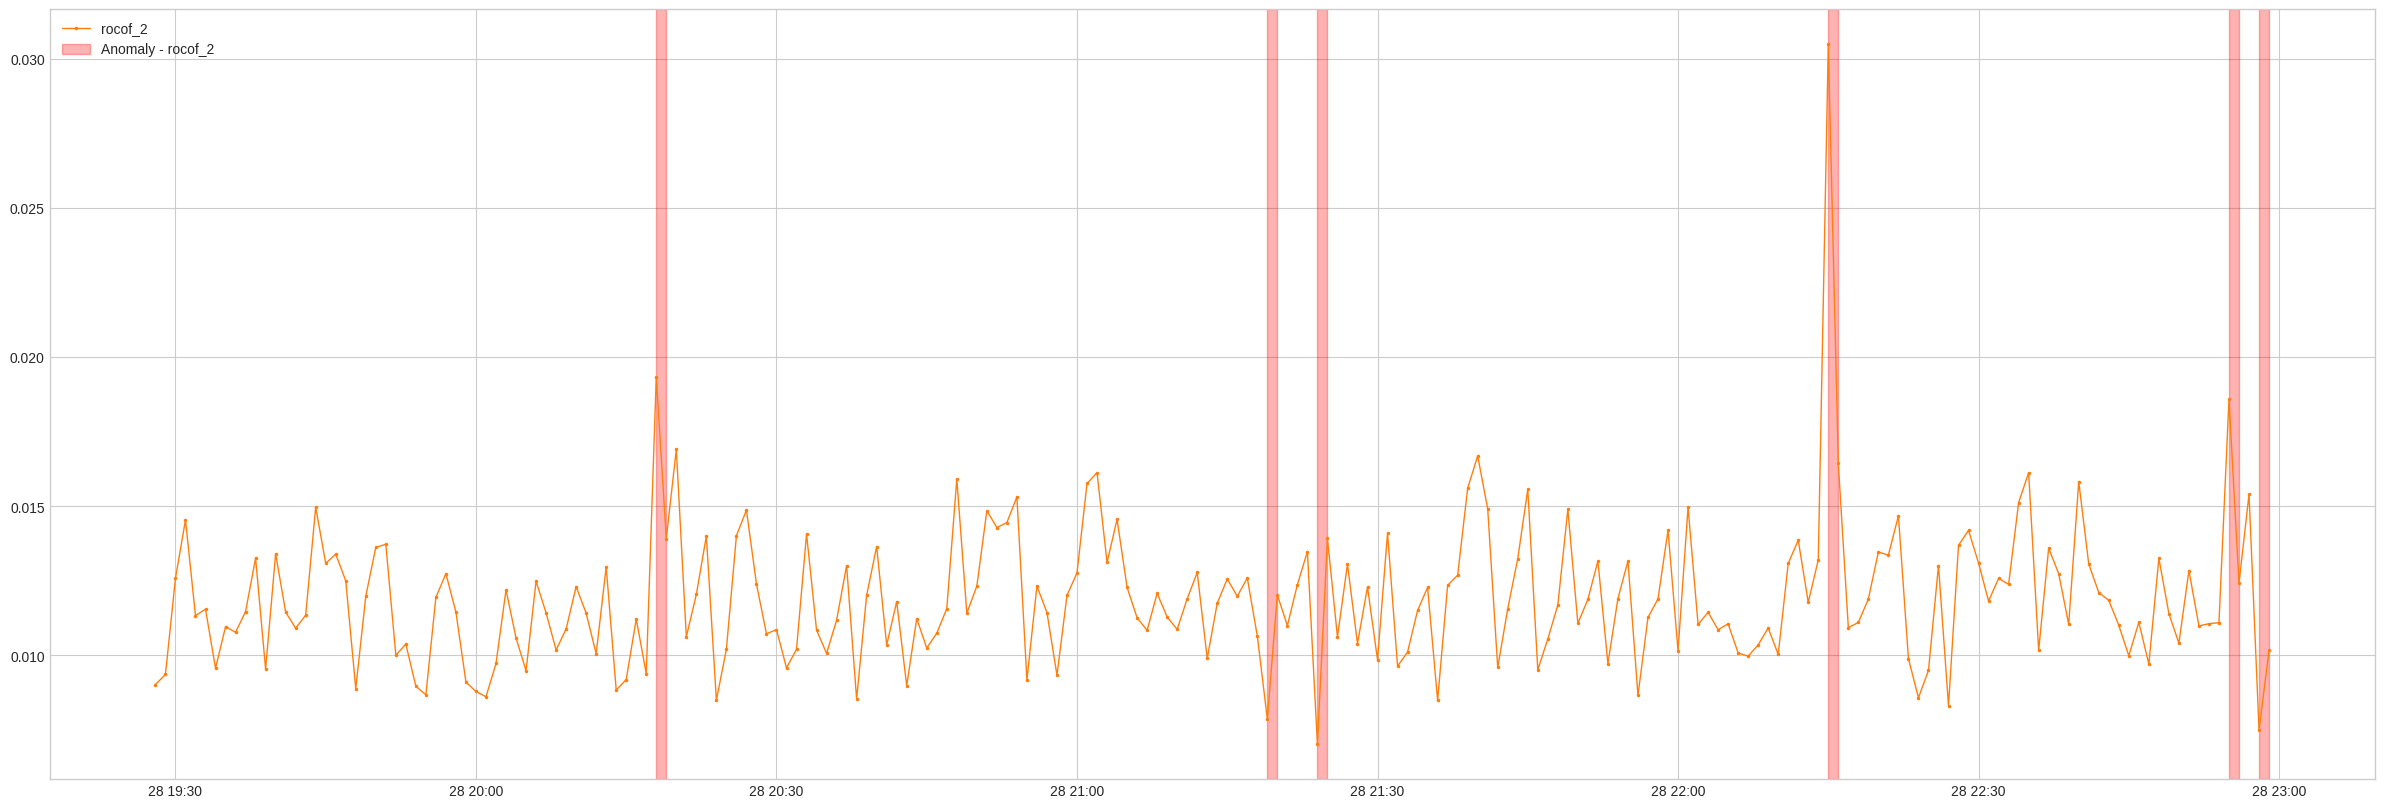

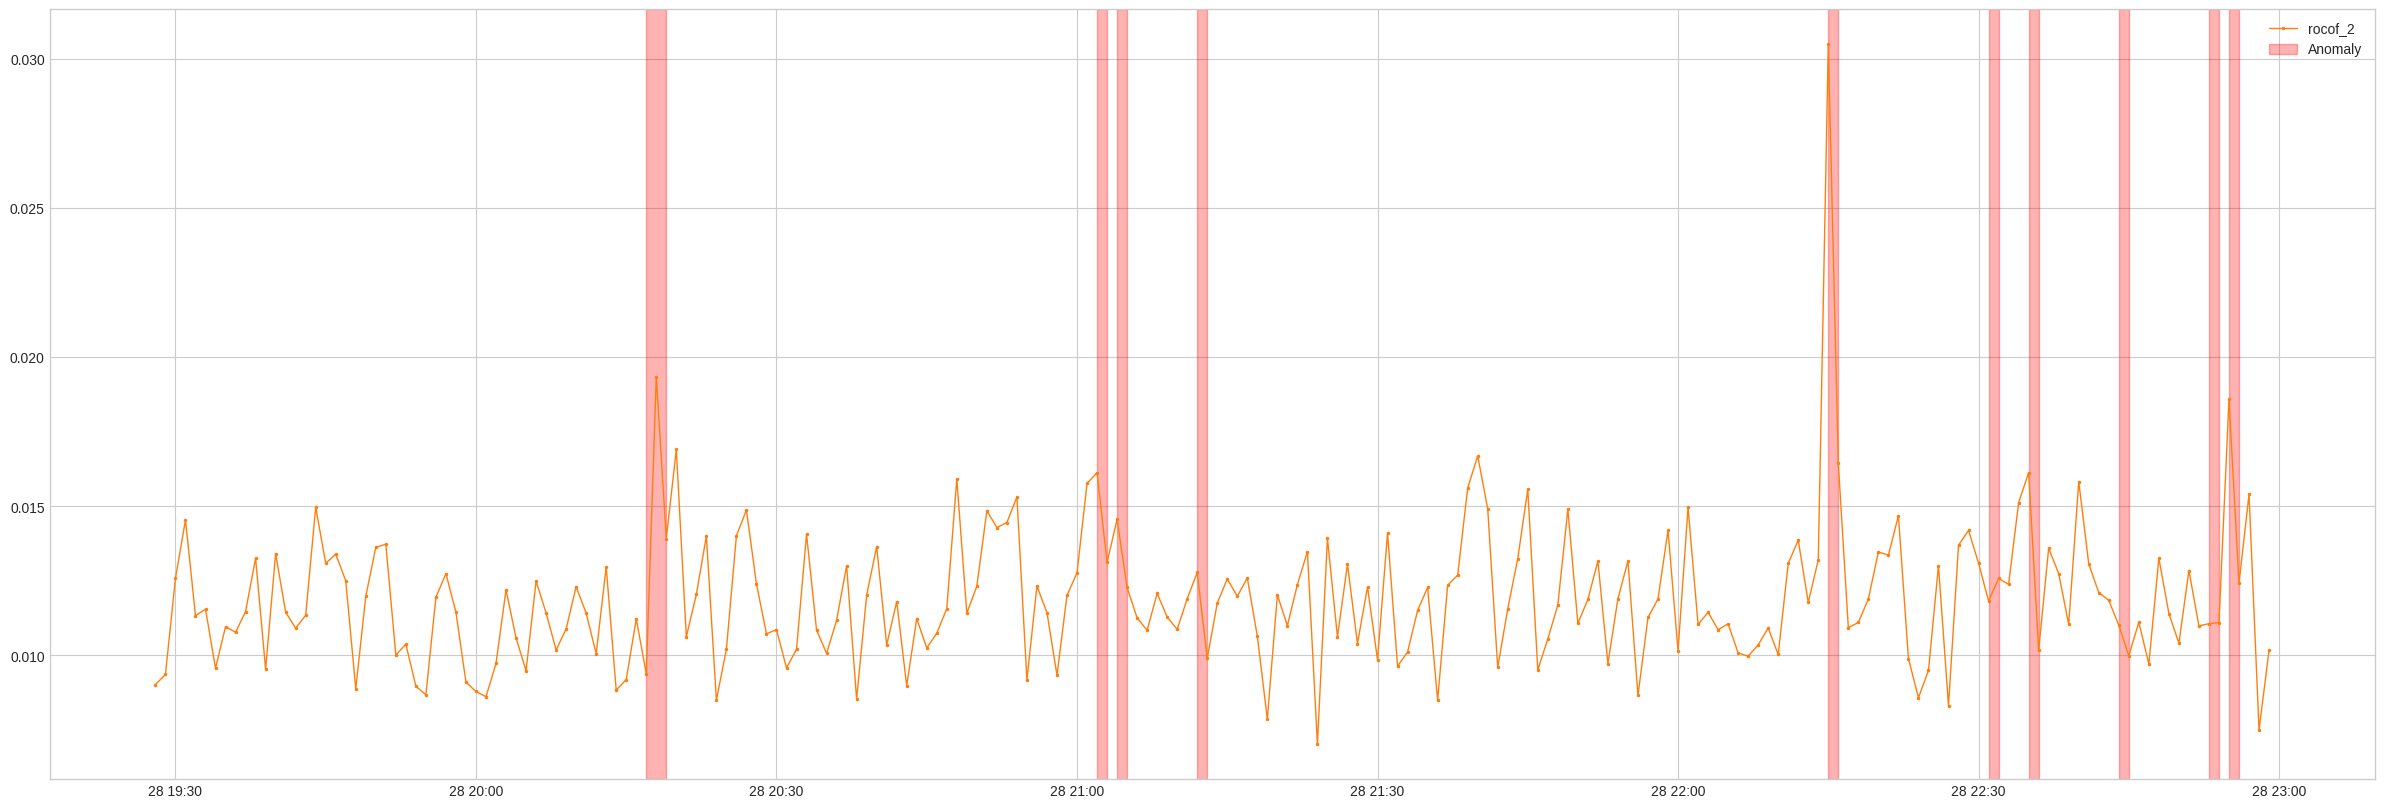

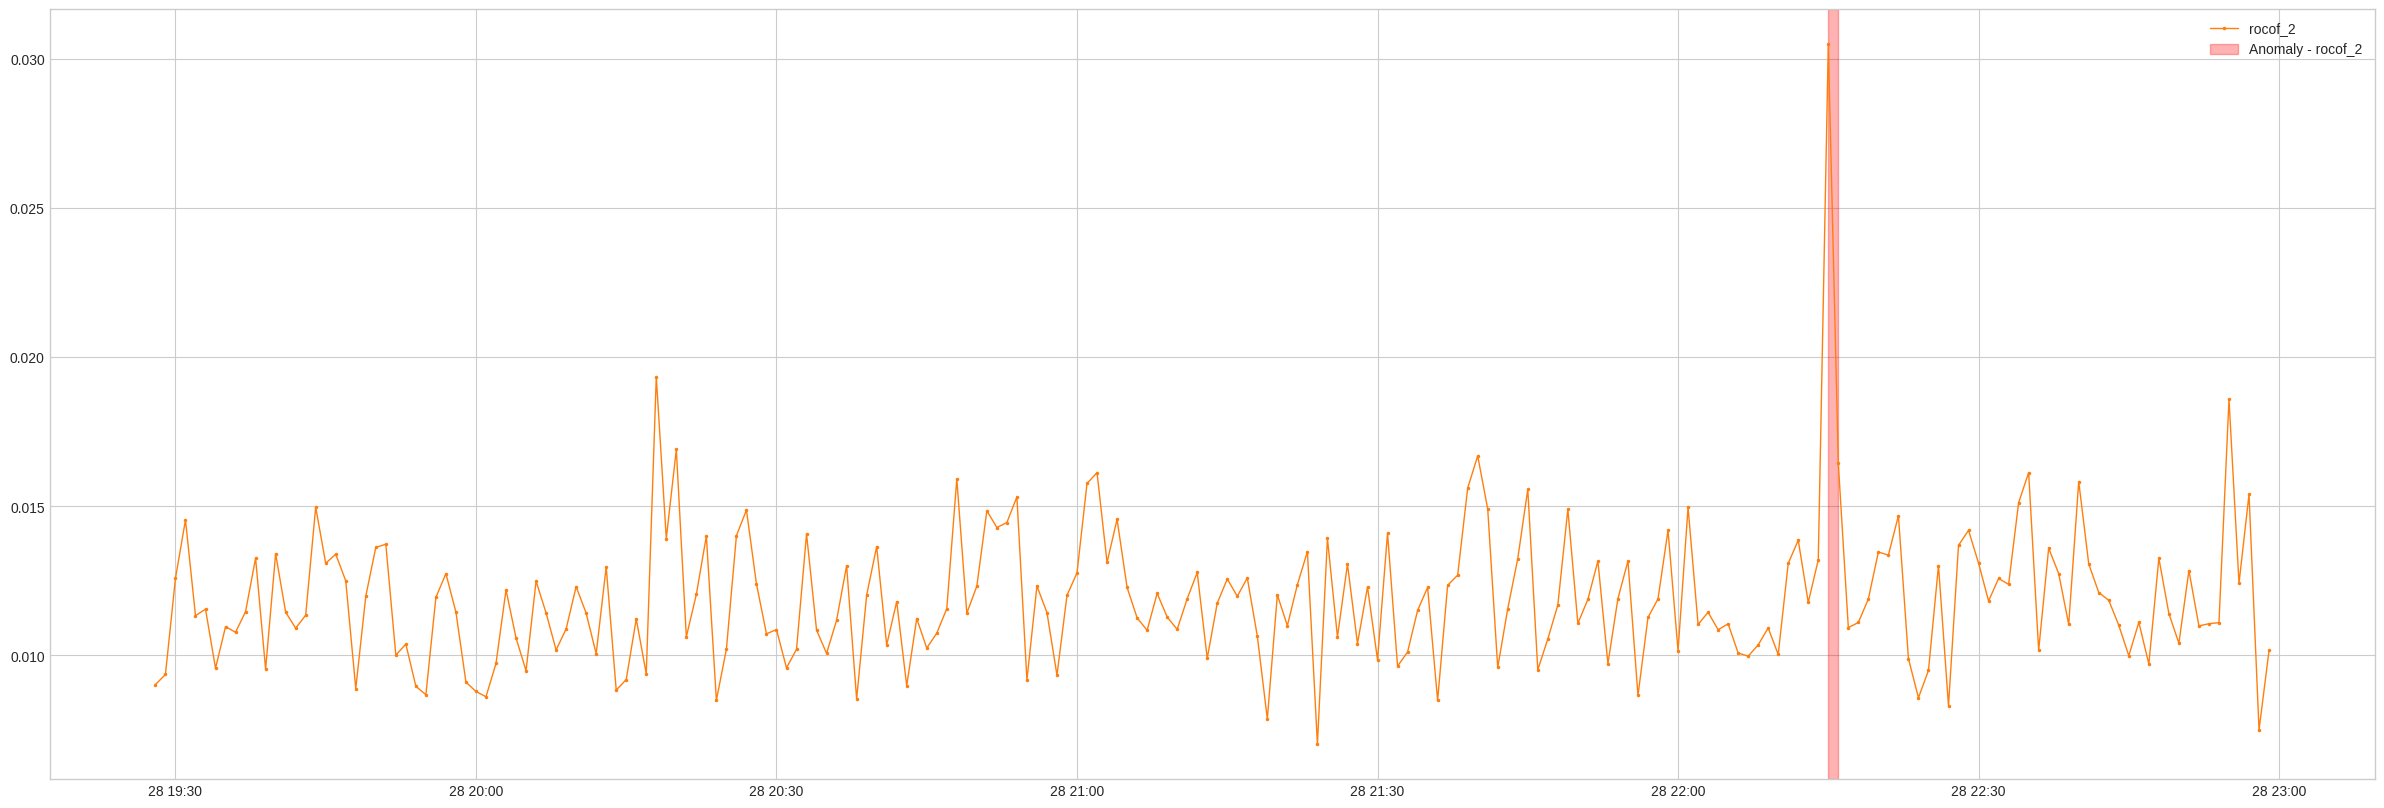

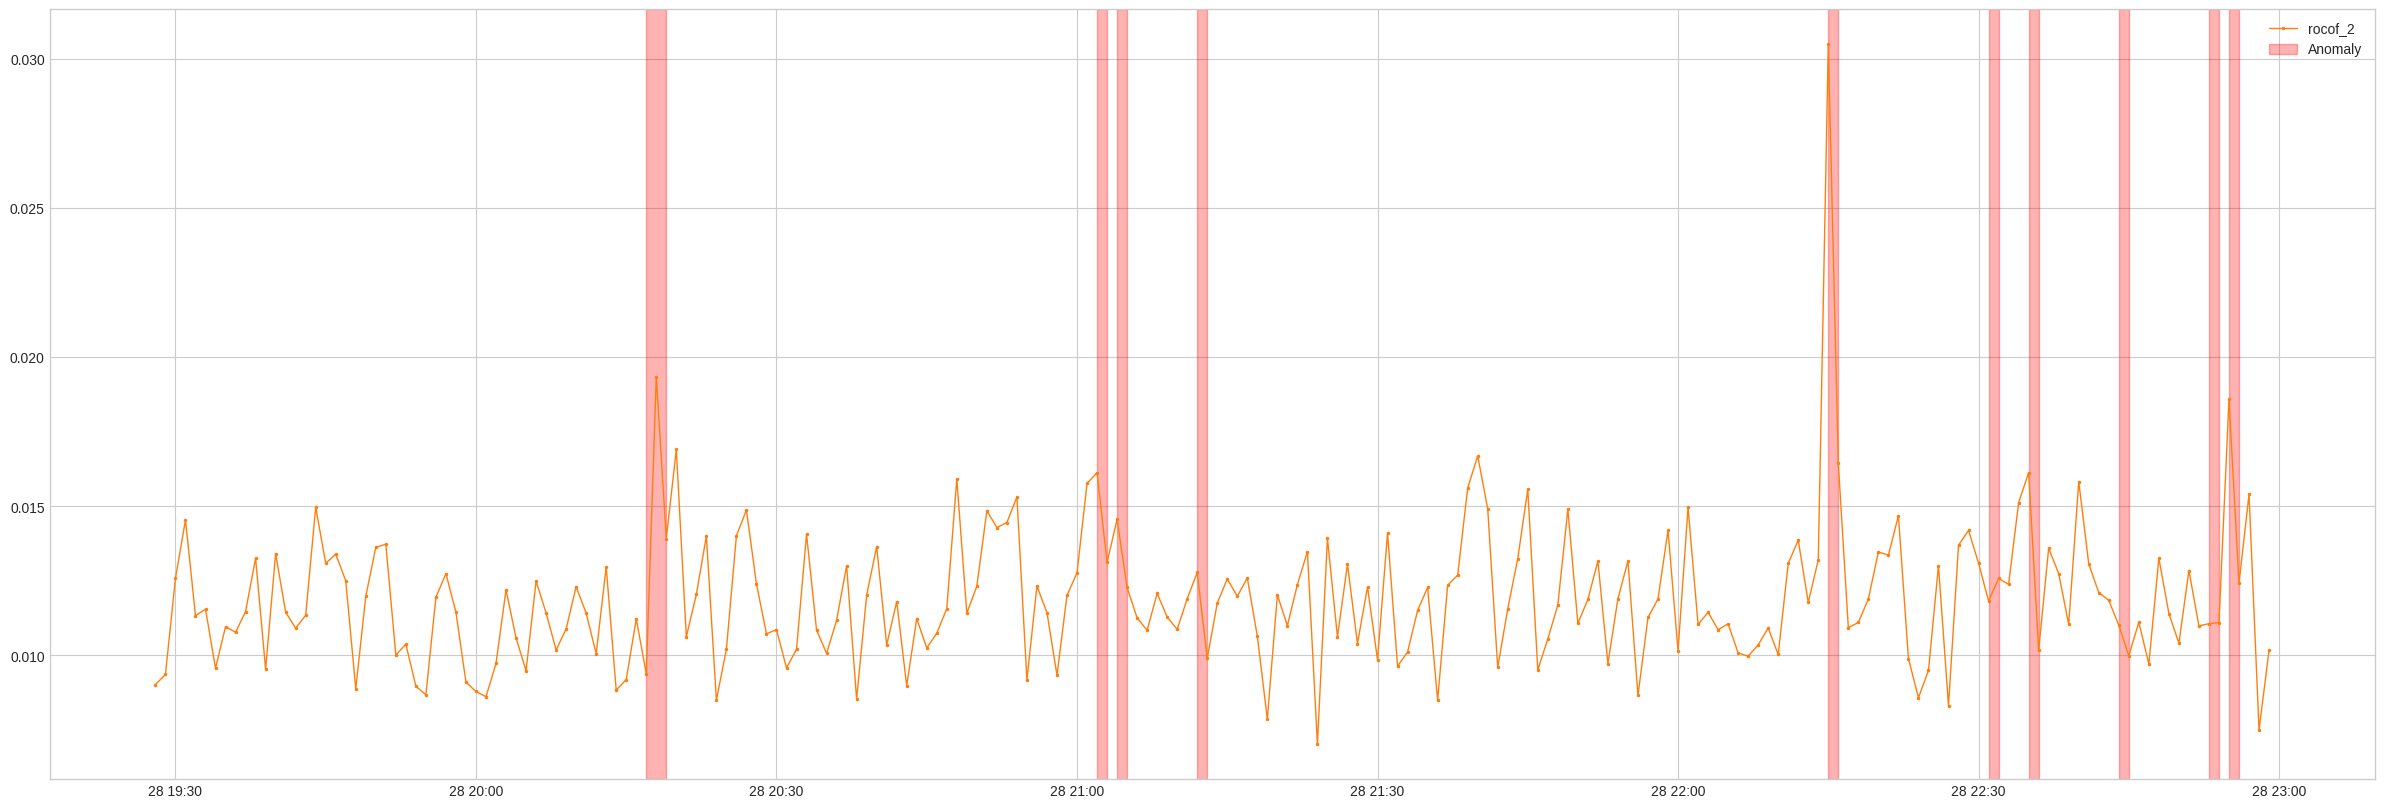

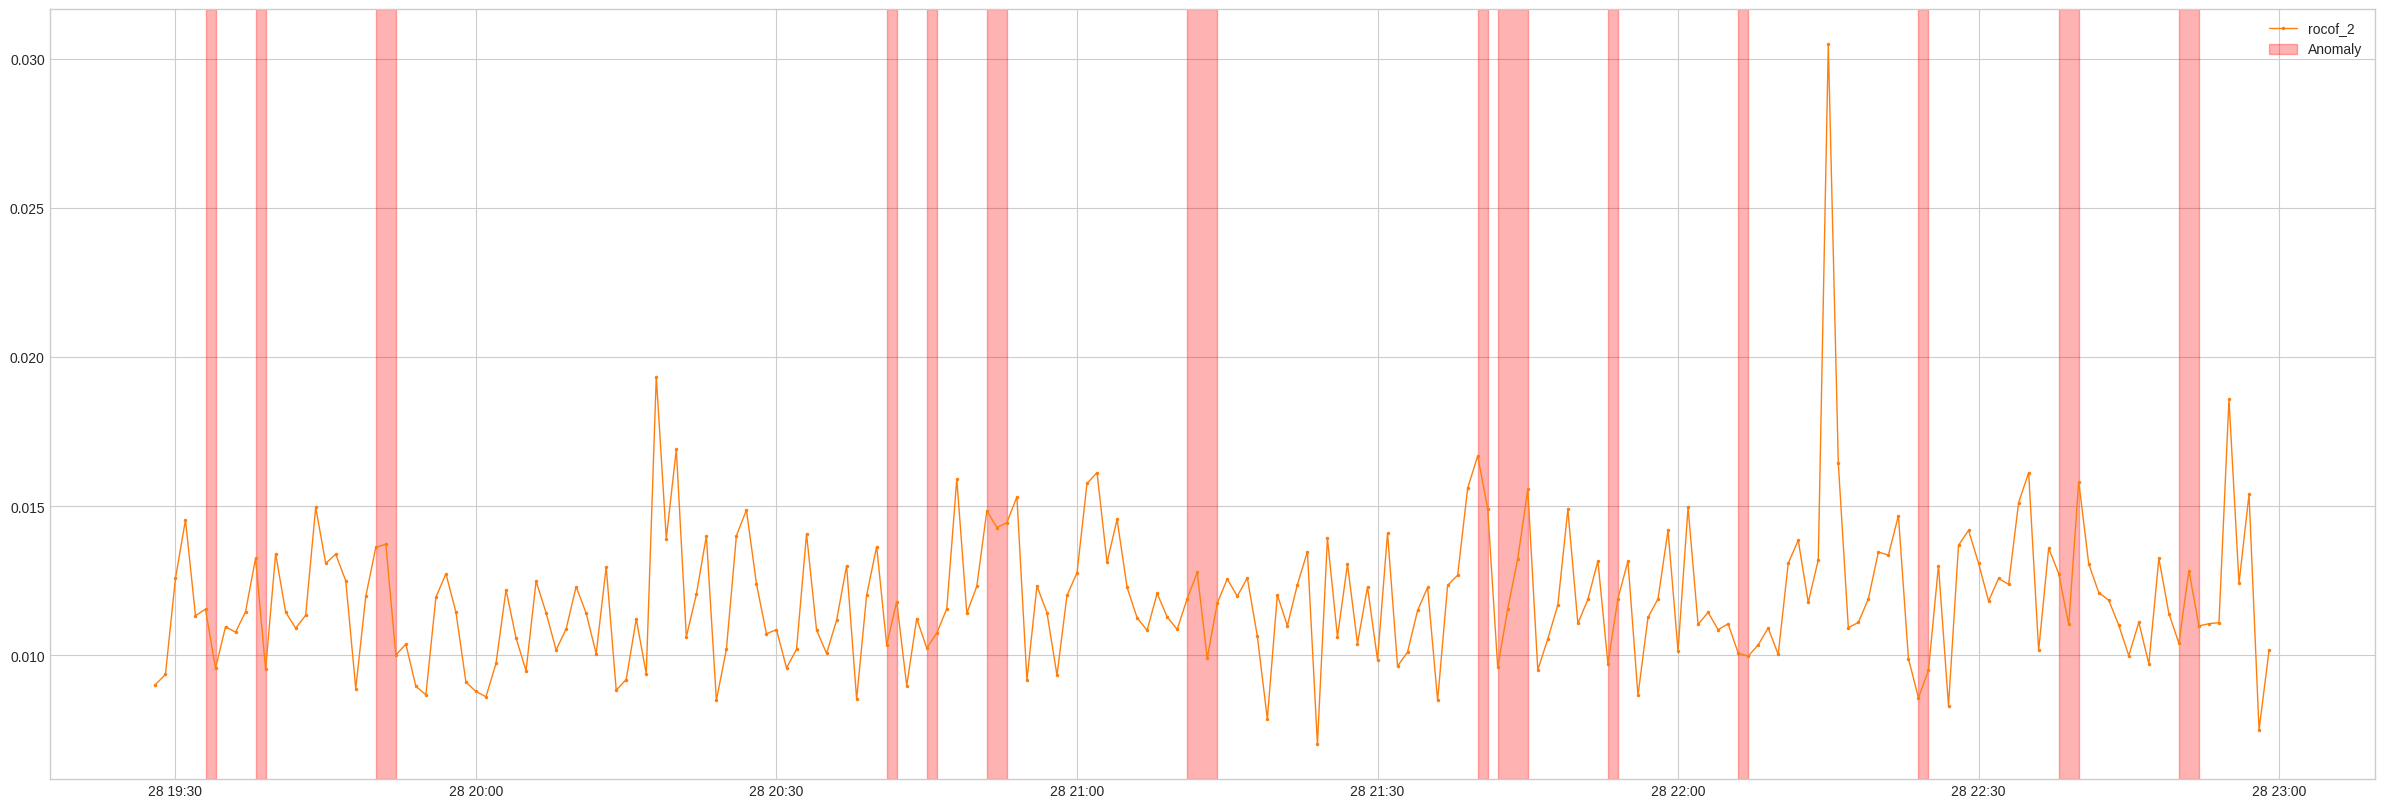

In [ ]:
from adtk.detector import SeasonalAD
from adtk.detector import QuantileAD
from adtk.detector import OutlierDetector
from adtk.detector import GeneralizedESDTestAD
from adtk.detector import MinClusterDetector
from adtk.detector import PcaAD
from adtk.data import validate_series
from adtk.visualization import plot
from sklearn.ensemble import IsolationForest

import warnings
import matplotlib.pyplot as plt

contaminantes = 0.05

detectores = [
    SeasonalAD(freq=24),
    QuantileAD(high=0.99, low=0.01),
    OutlierDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    GeneralizedESDTestAD(),
    MinClusterDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    PcaAD()
]

anomalias = pd.DataFrame()
serie_tot = pd.DataFrame()

for evento in eventos:
  df = medidas(parquets, evento)
  series = validate_series(df)
  #if serie_tot.empty:
  #  serie_tot = series
  #else:
  #  serie_tot = pd.concat([serie_tot, series], axis=0)

  for det in detectores:
    nomeDetector = det.__class__.__name__
    y_anom = det.fit_detect(series)
    anomalias = y_anom
    #if anomalias.empty:
    #  anomalias = y_anom
    #else:
    #  anomalias = pd.concat([anomalias, y_anom], axis=0)

    #verificando se existe a coluna no dataframe. Caso existir, popular a variavel curveColumns
    curveColumns = []
    if 'rocof' in series.columns:
      curveColumns.append('rocof')
    if 'rocof_2' in series.columns:
      curveColumns.append('rocof_2')

    warnings.filterwarnings('ignore')
    print('Nome detector:', nomeDetector, '\nEvento:', evento)
    plot(series, anomaly=anomalias, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group=curveColumns, figsize=(30,10))
    print('=================================================')